# Generative Models (160 + 40 points)

## Diffusion Models vs. GANs vs. VAE

### HW4 @ DL Course, Dr. Soleymani, Spring 2023

*Full Name:* MohammadHossein Sameti

*SID:* 401204932

In this notebook, we are going to implement Variational AutoEncoder (VAE), Denoising Diffusion Probabilistic Model (DDPM) and Generative Adversarial Network (GAN) on the FashionMNIST dataset. To generate images, these models convert noise to images from the training distribution, but the key difference is that Diffusion models denoise the image gradually. The following sections briefly describe each model.

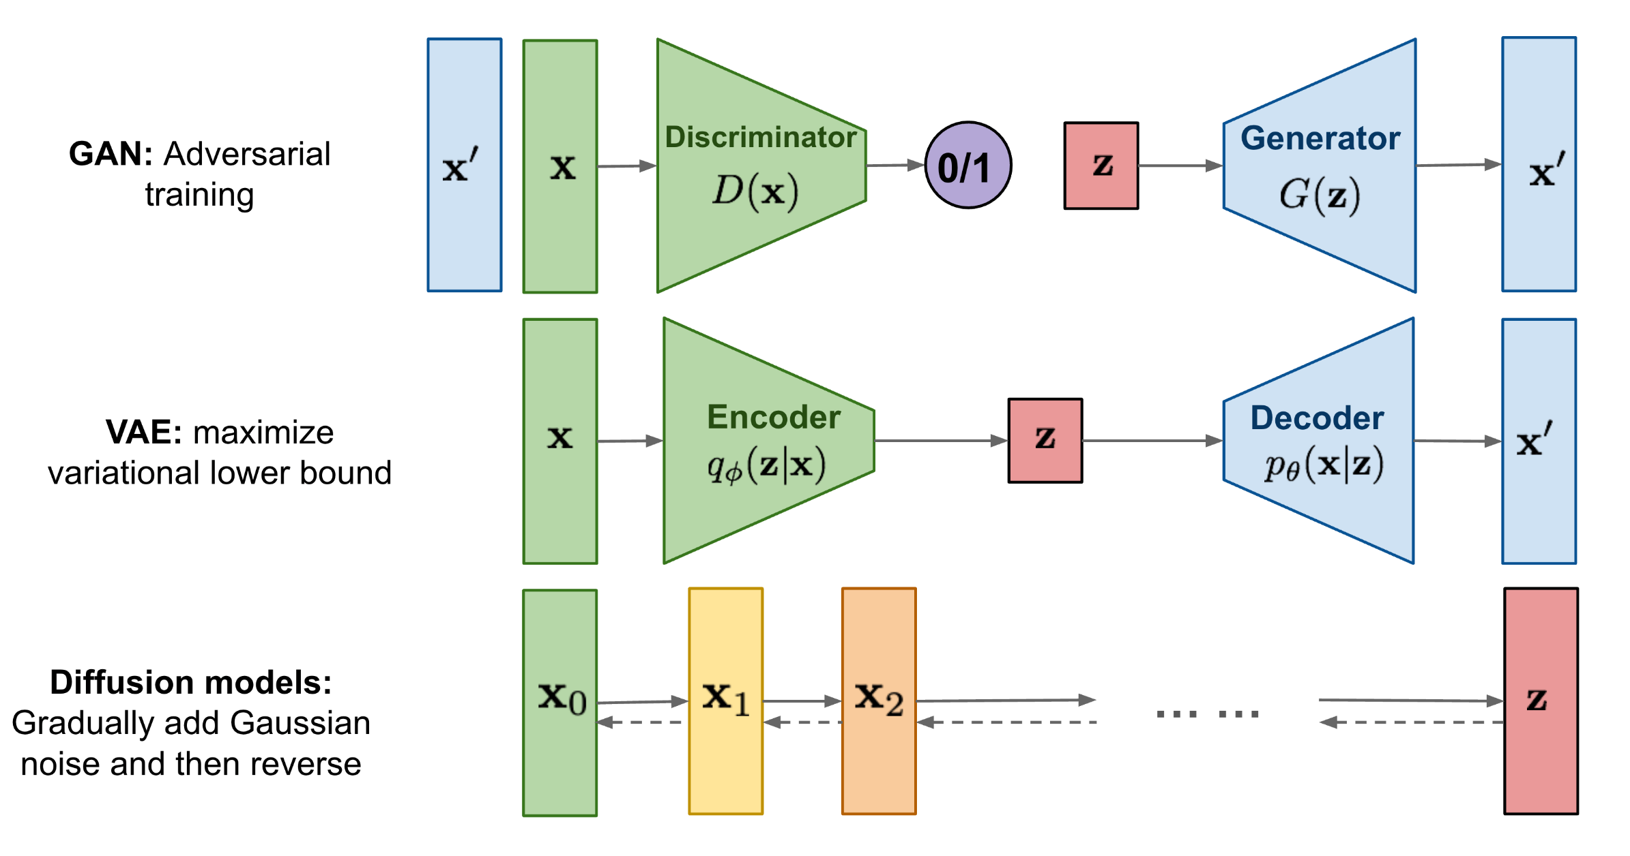

**NOTICE:** 
+ Please complete the code in the given structure. You may change the hyperparameters according to your computing power as long as the results indicate the desired performance.
+ Complete the `TODO` parts in the code accordingly. 
+ Remember to answer the conceptual questions. 

## Dataset

We are going to work on the FashionMNIST dataset. FashionMNIST consists of a training set of 60,000 examples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image associated with a label from 10 classes. We are going to use the training split in this notebook. You can use `dataloader` to train your models. Also, you can use `plot_samples` to plot a sequence of images (e.g. iteratively denoised images by DDPM).

In [3]:
from torchvision import transforms 
from torch.utils.data import DataLoader
from torch import optim
from tqdm.notebook import tqdm
from torch.autograd import Variable 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

BATCH_SIZE = 16
IMG_SIZE = 32 
C_IN = 1 # Number of input channels
LR = 1e-3
EPOCHS = 100

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

100%|██████████| 26421880/26421880 [00:03<00:00, 8272522.89it/s] 


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 139359.53it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2672532.50it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6111598.36it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



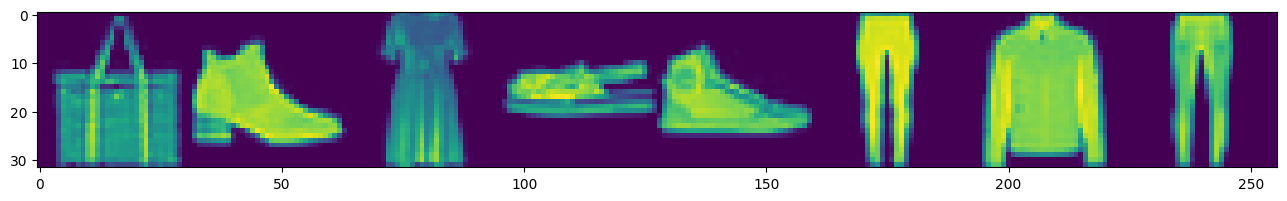

In [4]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  
        transforms.Lambda(lambda t: (t * 2) - 1) 
    ]

    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.FashionMNIST(root=".", download=True, 
                                         train=True, transform=data_transform)
    return data


def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, 
                        shuffle=True, drop_last=True)
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

## DDPM (73 + 25 points)

Denoising diffusion probabilistic models (DDPMs) learn to generate images by gradually denoising a completely random pattern in a step-by-step process. The model learns a set of diffusion steps that describe how the noise evolves through time and a denoising function that removes the noise at each time step. The denoising function is typically implemented as a neural network that takes in the noisy data and the time step as input and outputs the denoised data. After iterative denoising steps over a time index, an image from the training distribution is generated. The overall procedure of training and sampling from DDPM is represented in the following pseudocodes from DDPM paper. For more details on the loss function and the sampling process, please refer to the course slides and the paper.

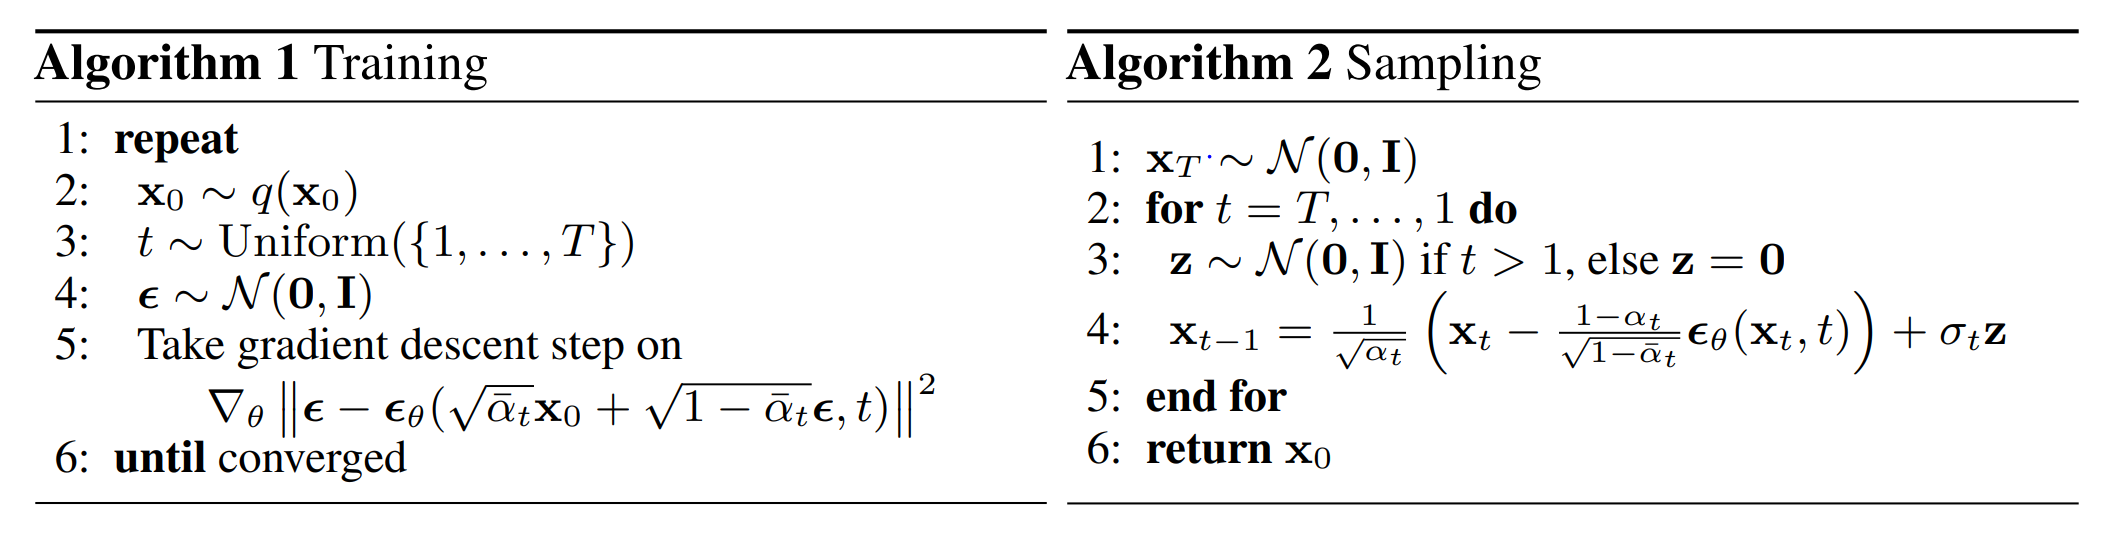

The pseudocode shows that the loss function is defined as an MSE on per time step noise and the predicted noise for the current time step. So we only need to train a model that learns to reverse the noise from an input image at a specific time step. In this notebook, we will use the architecture proposed by the paper, a UNet with image and time as the inputs and predicted noise as the output. They augment the regular UNet with several sub-modules and techniques such as ResNets, Attention modules, etc. We describe the expected architecture for this notebook:

+ *ResNet:* As a base sub-module, we define each ResNet block as two consecutive convolutional layers with a GELU activation in between and Group Normalization after each convolutional layer. You can use this module in Down/Up blocks. Also, by removing the residual connection, you can use this block as a convolutional network throughout the network.
+ *Attention:* This is also a sub-module consisting of a Layer Normalization, Multi-head Attention (use from `torch.nn`), a residual connection, a feed-forward network, and another residual connection.
+ *Conditional UNet:* Each Up/Down block in UNet accepts positionally-encoded time as an input. The time index is encoded and added to the output of the block. You can use the sinusoidal position embeddings proposed in [Attention is All You Need.](https://arxiv.org/pdf/1706.03762.pdf)

You can implement the following structure for UNet:

+ Convolutional block
+ Down block
+ Attention 
+ Down block
+ Attention
+ Down block
+ Attention

+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)

+ Up block
+ Attention
+ Up block
+ Attention
+ Up block
+ Attention
+ Convolutional block

### ❓ **Question 4**
> + *(4 points)* How can we generate images from a specific target class in DDPM?

اضافه کردن امبدینگ برچسب ها که تعدادشون ۱۰ تاست به شبکه UNET
+ *(Bonus - 25 points)* Implement your idea and plot one trajectory of denoised images per class.

In [52]:

class ConvResNet(nn.Module):
    def __init__(self, in_c=1, out_c=1 , mid_c=32, res=False, activation=False, *args, **kwargs):
        super(ConvResNet, self).__init__()
        self.res = res
        self.twocon = nn.Sequential(
            nn.Conv2d(in_c, mid_c, kernel_size=3, padding='same'),
            nn.GroupNorm(1, mid_c),
            nn.GELU() ,
            nn.Conv2d(mid_c, out_c, kernel_size=3, padding='same'),
            nn.GroupNorm(1, out_c)
            
        )
        self.act = activation
        self.tanh = nn.Tanh()
        

    def forward(self, x):
        if self.res : 
          res = self.twocon(x)
          res = F.gelu(res + x)
        else:
          res = self.twocon(x)
        if self.act:
          res = self.tanh(res)
        return res


class Down(nn.Module):
    def __init__(self, in_c=1, out_c=1, mid_c=32, in_dim=1000, *args, **kwargs):
        super(Down, self).__init__()
        self.resnet = nn.Sequential(
            nn.MaxPool2d(2),
            ConvResNet(in_c, in_c, in_c, res=True),
            ConvResNet(in_c, out_c, mid_c)
            )
        self.emb = nn.Embedding(in_dim, out_c, device=DEVICE)
        self.lemb = nn.Embedding(10, out_c, device=DEVICE)
        '''self.emb_layer = nn.Sequential(
            nn.Linear(in_dim, in_dim, device=DEVICE),
            nn.SiLU(),
            nn.Linear(in_dim, out_c, device=DEVICE),
        )'''
        
    def forward(self, x, t, y):
        x = self.resnet(x)
        t = self.emb(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        y = self.lemb(y)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        x = x + t + y
        
        return x


class Up(nn.Module):
    def __init__(self, in_c=1, out_c=1, mid_c=32, in_dim=1000, *args, **kwargs):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_c//2, in_c//2, 4, 2, 1)
        self.resnet = nn.Sequential(
            ConvResNet(in_c, in_c, in_c, res=True),
            ConvResNet(in_c, out_c, mid_c)
        )
        self.emb = nn.Embedding(in_dim, out_c, device=DEVICE)
        self.lemb = nn.Embedding(10, out_c, device=DEVICE)
        #self.emb.requires_grad_(False)
        '''self.emb_layer = nn.Sequential(
            nn.Linear(in_dim, in_dim, device=DEVICE),
            nn.SiLU(),
            nn.Linear(in_dim, out_c, device=DEVICE),
        )'''
    def forward(self, x, skip, t, y):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.resnet(x)
        t = self.emb(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        y = self.lemb(y)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        x = x + t + y
        return x


class Attention(nn.Module):
    def __init__(self, channels, size):
        super(Attention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class UNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super(UNet, self).__init__()
        

        self.bott0 = ConvResNet(1 , 32, 1)   #(batch_size, 64, 32, 32)
        self.down1 = Down(32, 64)       #(batch_size, 64, 16, 16)
        self.a1 = Attention(64, 16)   
        self.down2 = Down(64, 128, 64)      #(batch_size, 256, 8, 8)
        self.a2 = Attention(128, 8)
        self.down3 = Down(128, 256, 128) #(batch_size, 512, 4, 4)
        self.a3 = Attention(256, 4)
        self.bott1 = ConvResNet(256, 512, 256, k=1) #(batch_size, 1024, 4, 4)
        self.bott2 = ConvResNet(512, 256, 512, k=1) #(batch_size, 512, 4, 4)
        self.bott3 = ConvResNet(256, 128, 256, k=1) #(batch_size, 256, 4, 4)
        self.up1 = Up(256, 64, 256)    #(batch_size, 128, 8, 8)
        self.a4 = Attention(64, 8)
        self.up2 = Up(128, 32, 128)    #(batch_size, 64, 16, 16)
        self.a5 = Attention(32, 16)
        self.up3 = Up(64, 16, 64)     #(batch_size, 32, 32, 32)
        self.a6 = Attention(16, 32)
        #self.bott4_ = ConvResNet(16, 1, 16, k=1)
        self.bott4 = ConvResNet(16, 1, 16, k=1)  #(batch_size, 1, 32, 32)
    def forward(self, x, t, y):
        '''t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, 256)
'''
        d0 = self.bott0(x)
        d1 = self.down1(d0, t, y)
        #print('d1', d1.shape)
        d1 = self.a1(d1)
        d2 = self.down2(d1, t, y)
        #print('d2', d2.shape)
        d2 = self.a2(d2)
        d3 = self.down3(d2, t, y)
        #print('d3', d3.shape)
        x = self.a3(d3)
        x = self.bott1(x)
        x = self.bott2(x)
        #print('x', x.shape)
        x = self.bott3(x)
        #print('x', x.shape)
        x = self.up1(x, d2, t, y)
        #print('x1', x.shape)
        x = self.a4(x)
        x = self.up2(x, d1, t, y)
        #print('x2', x.shape)
        x = self.a5(x)
        x = self.up3(x, d0, t, y)
        #print('x3', x.shape)
        x = self.a6(x)
        x = self.bott4(x)
        '''idx = t[:,None,None,None].to(DEVICE)
        x = torch.where(idx!=1, x, F.tanh(x))'''
        return x

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=DEVICE).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    

In [61]:
import torch
import torch.optim as optim
import numpy as np
from tqdm import tqdm
EPOCHS = 10
class DDPMManager():
    def __init__(self, *args, **kwargs):

        self.T = 1000
        self.beta_start = 1e-4
        self.beta_end = 0.02

        self.unet = UNet().to(DEVICE)
        self.optimizer = optim.Adam(self.unet.parameters(), lr=LR)
        
        model_parameters = filter(lambda p: p.requires_grad, self.unet.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print(params)
        self.beta = torch.linspace(self.beta_start, self.beta_end, self.T, device=DEVICE)
        self.alpha = 1 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        #print(self.alpha_hat.shape, self.beta.shape, self.alpha.shape)
        self.loss = nn.MSELoss()
    
    def train(self, dataloader):

        history = dict(loss=[])
        for epoch in range(EPOCHS):
            total_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)
                batch_y = _.to(DEVICE)
                t = torch.randint(low=1, high=self.T, size=(batch_x.shape[0],)).to(DEVICE)

                alpha_hat = torch.sqrt(self.alpha_hat[t]).reshape(16, 1, 1, 1)
                alpha_hat_m = torch.sqrt(1 - self.alpha_hat[t]).reshape(16, 1, 1, 1)
                noise = torch.randn_like(batch_x, device=DEVICE)
                #print(alpha_hat.shape, alpha_hat_m.shape, batch_x.shape, noise.shape)
                x_t = (alpha_hat * batch_x) + (alpha_hat_m * noise)
                
                
                self.optimizer.zero_grad()
                noise_pred = self.unet(x_t, t, batch_y)
                
                loss = self.loss(noise, noise_pred)
                loss.backward()
                self.optimizer.step()

                total_loss.append(loss.item())

            mean_loss = np.mean(total_loss)
            print(
                "[Epoch: %d/%d] [loss: %.4f]"
                % (epoch+1, EPOCHS, mean_loss)
            )
            l = epoch %10
            y = batch_y * 0 + l

            self.sample(8, y[:8], plot=True)

            history['loss'].append(mean_loss)

        return history
    
    def sample(self, n, y,plot=True):

        
        with torch.no_grad():
            x = torch.randn((n, 1, 32, 32)).to(DEVICE)
            for i in tqdm(list(range(self.T))[::-1]):
                t = (torch.ones(n) * i).long().to(DEVICE)
                predicted_noise = self.unet(x, t, y)
                alpha = self.alpha[t].reshape(8, 1, 1, 1)
                alpha_hat = self.alpha_hat[t].reshape(8, 1, 1, 1)
                sigma_t = self.beta[t].reshape(8, 1, 1, 1)
                x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat) * predicted_noise))
                if i > 1:

                  z = torch.randn_like(x)
                  x = x + torch.sqrt(sigma_t) * z
                
                '''tmp = torch.max(torch.abs(x))
                  #x = (x.clamp(-1, 1))
                if tmp > 1 :
                  x = x / tmp.item()'''
                if plot and (i%100==0):
                  maxx = torch.tensor([torch.max(i) for i in x]).view(-1, 1).to(DEVICE)

                  #x = (x.clamp(-1, 1))
                  x = (x.reshape(8, -1) / maxx ).reshape(-1, 1, 32, 32)
                  plot_images(x)
            
            plot_images(x) 
                


11157023


100%|██████████| 3750/3750 [03:52<00:00, 16.14it/s]


[Epoch: 1/10] [loss: 0.0712]


 10%|▉         | 96/1000 [00:01<00:12, 71.31it/s]

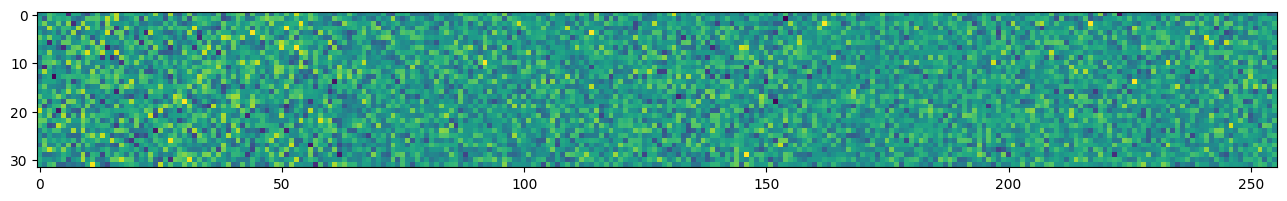

 19%|█▉        | 192/1000 [00:02<00:11, 69.35it/s]

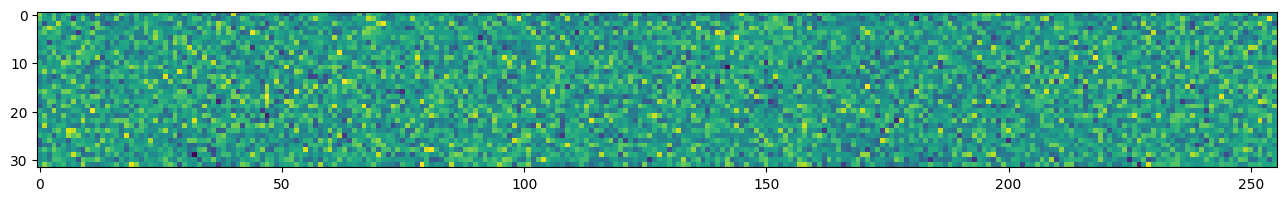

 29%|██▉       | 294/1000 [00:04<00:10, 70.31it/s]

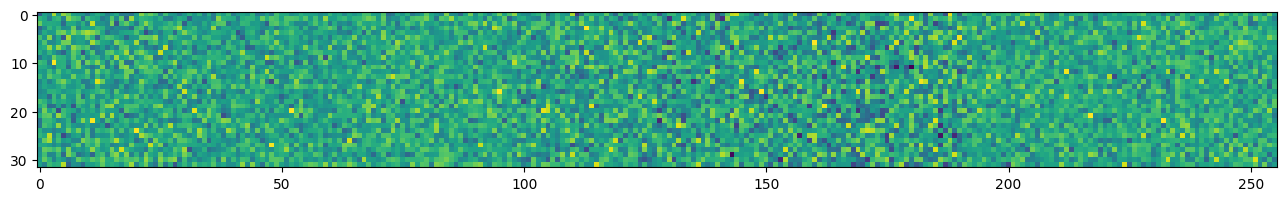

 40%|███▉      | 396/1000 [00:06<00:08, 71.38it/s]

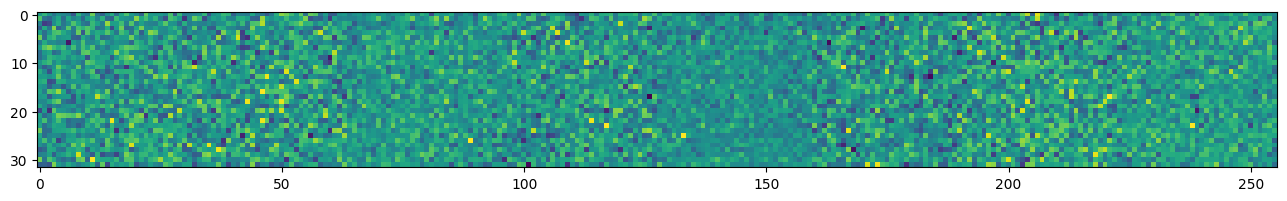

 50%|████▉     | 497/1000 [00:07<00:07, 67.81it/s]

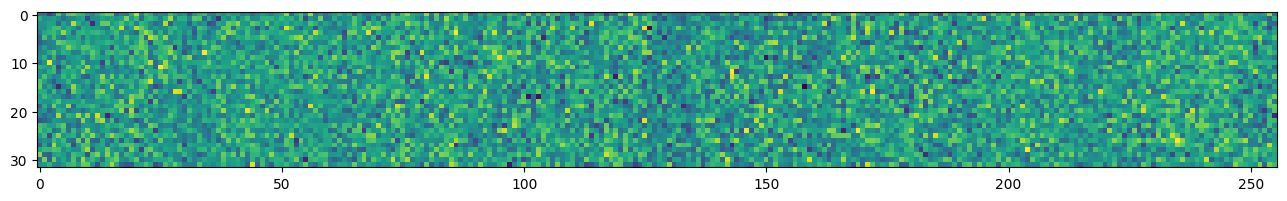

 59%|█████▉    | 594/1000 [00:09<00:07, 53.90it/s]

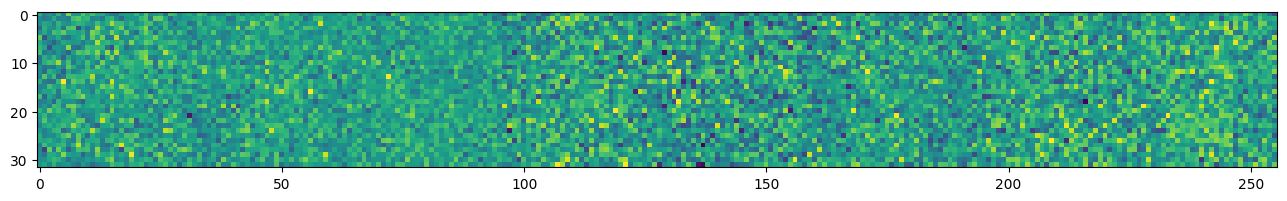

 70%|██████▉   | 697/1000 [00:11<00:04, 67.83it/s]

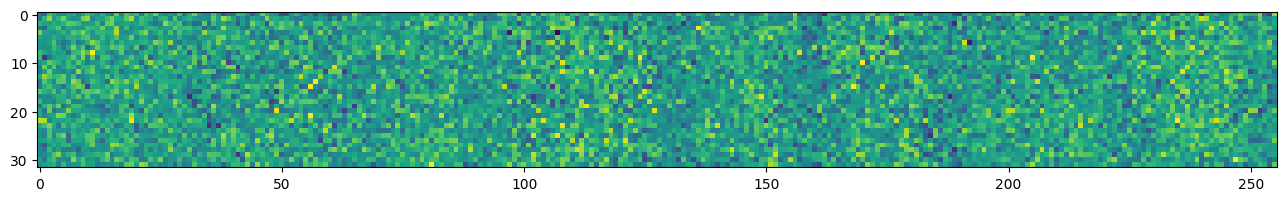

 80%|███████▉  | 796/1000 [00:13<00:02, 68.78it/s]

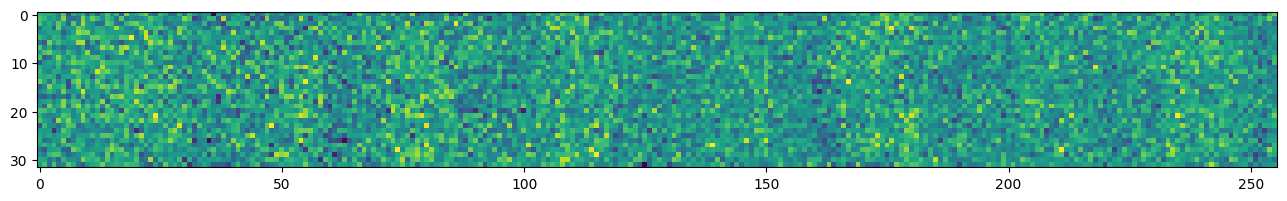

 90%|████████▉ | 899/1000 [00:14<00:01, 68.97it/s]

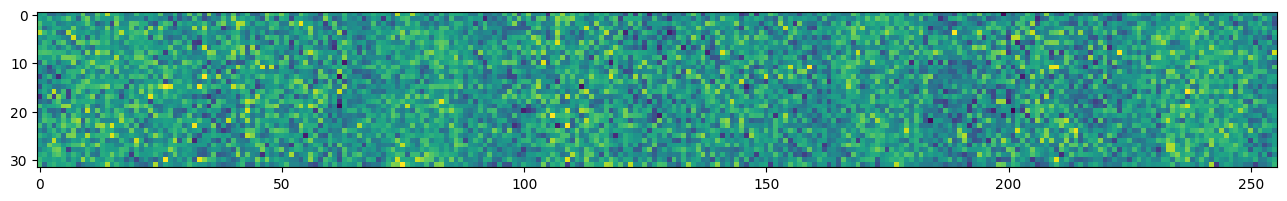

100%|█████████▉| 997/1000 [00:16<00:00, 70.09it/s]

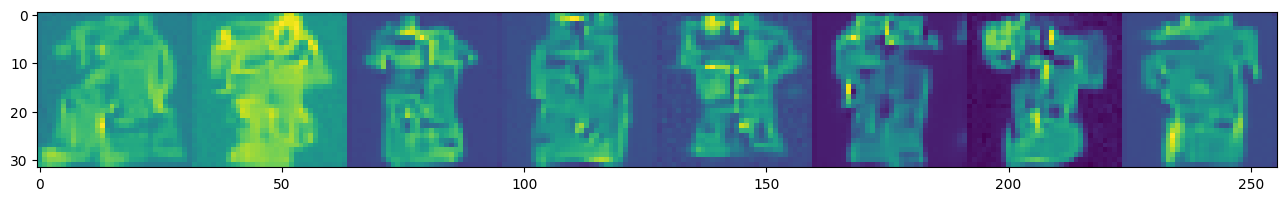

100%|██████████| 1000/1000 [00:16<00:00, 60.70it/s]


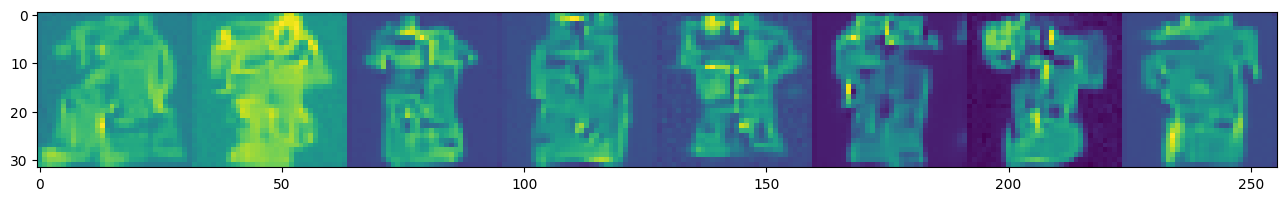

100%|██████████| 3750/3750 [03:57<00:00, 15.82it/s]


[Epoch: 2/10] [loss: 0.0372]


  9%|▉         | 93/1000 [00:01<00:13, 67.02it/s]

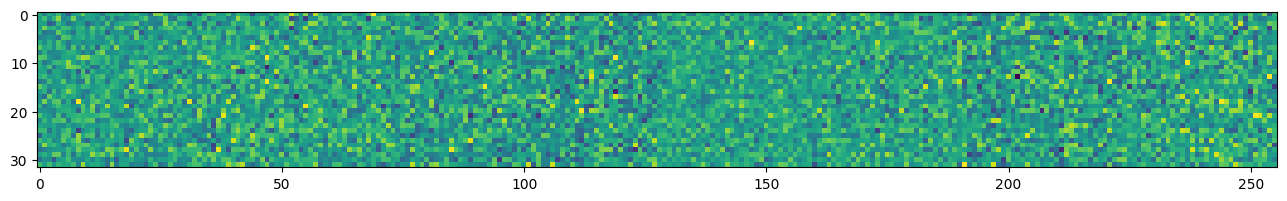

 19%|█▉        | 193/1000 [00:03<00:11, 68.25it/s]

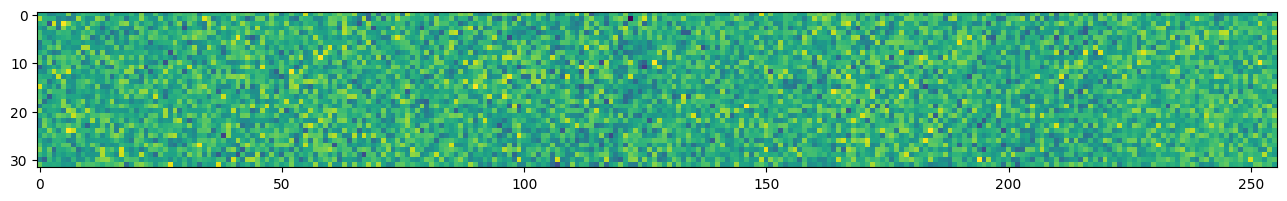

 30%|██▉       | 295/1000 [00:04<00:10, 69.44it/s]

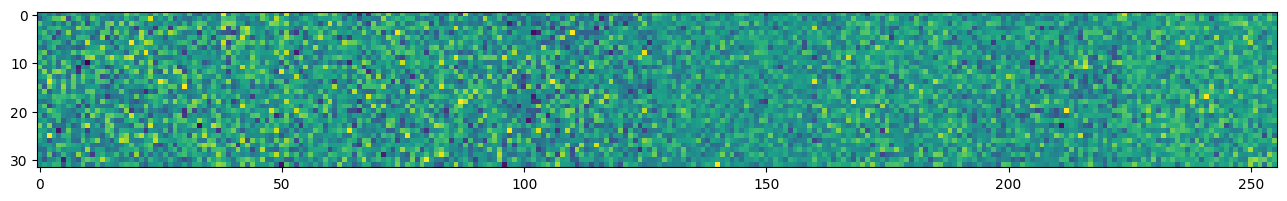

 40%|███▉      | 396/1000 [00:06<00:08, 68.21it/s]

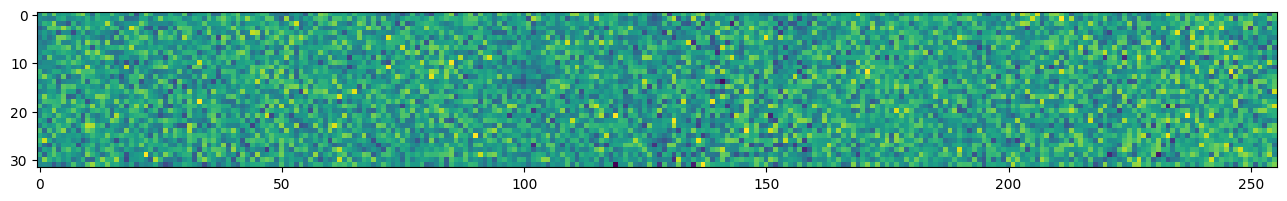

 50%|████▉     | 497/1000 [00:08<00:07, 67.83it/s]

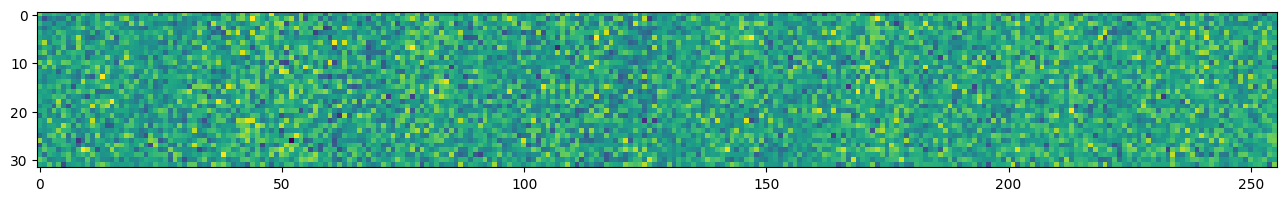

 60%|█████▉    | 597/1000 [00:09<00:05, 68.83it/s]

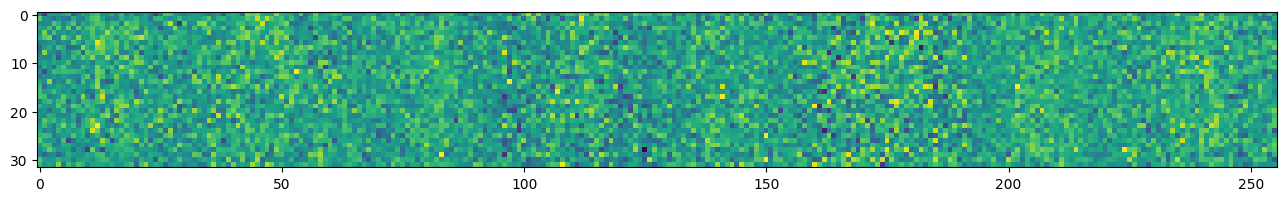

 70%|██████▉   | 696/1000 [00:11<00:05, 54.14it/s]

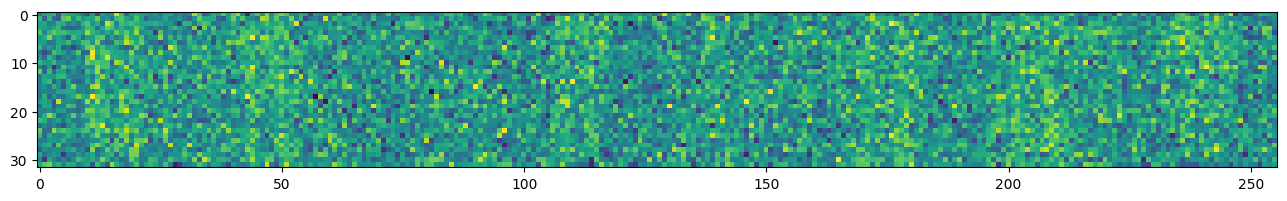

 80%|███████▉  | 797/1000 [00:13<00:03, 64.55it/s]

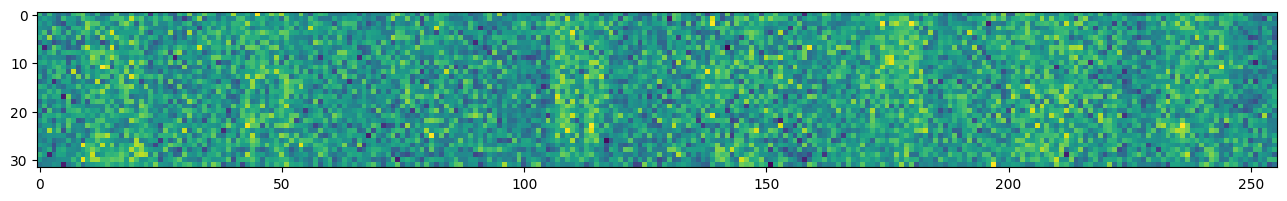

 90%|████████▉ | 898/1000 [00:15<00:01, 67.45it/s]

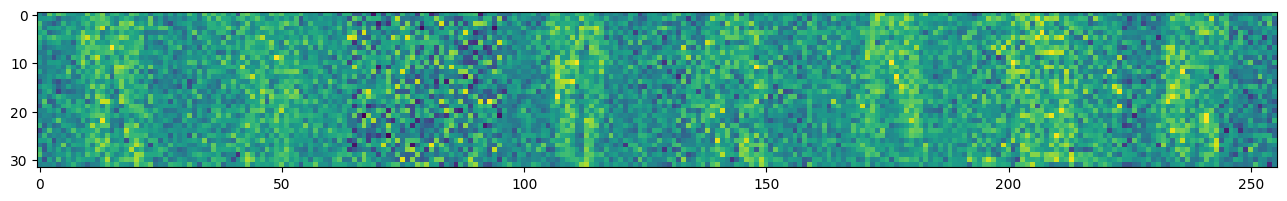

100%|█████████▉| 997/1000 [00:16<00:00, 68.69it/s]

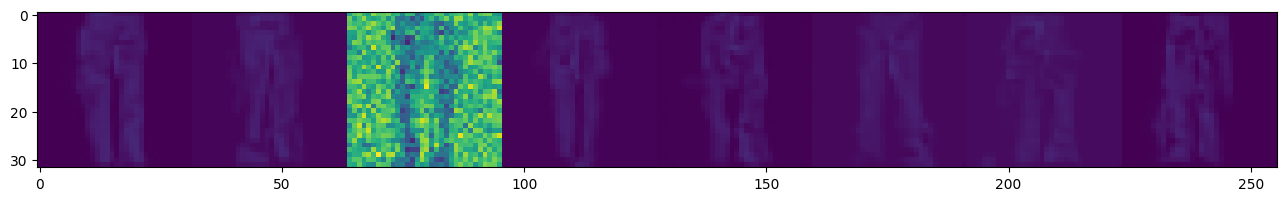

100%|██████████| 1000/1000 [00:17<00:00, 58.76it/s]


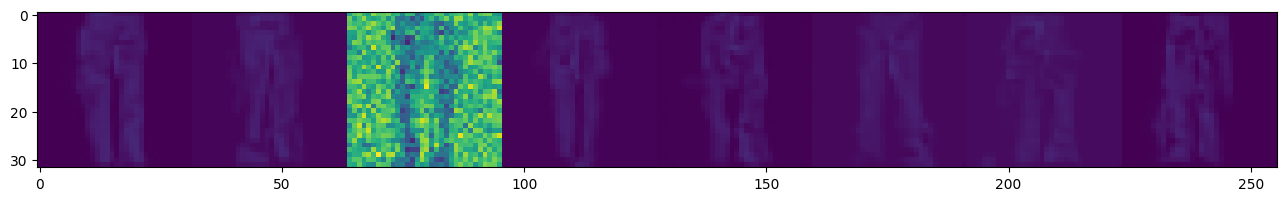

100%|██████████| 3750/3750 [04:00<00:00, 15.60it/s]


[Epoch: 3/10] [loss: 0.0332]


 10%|▉         | 99/1000 [00:01<00:14, 64.18it/s]

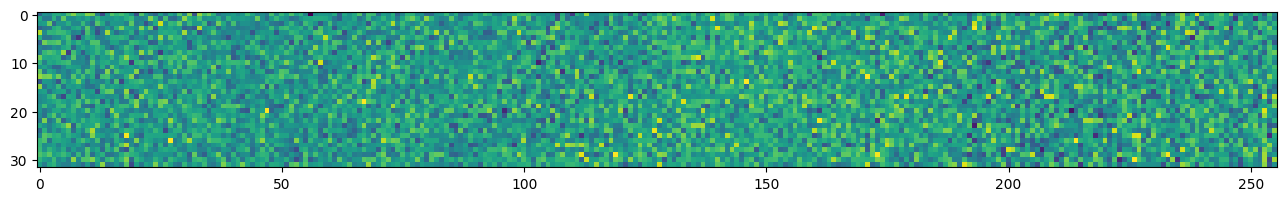

 20%|█▉        | 198/1000 [00:03<00:11, 68.04it/s]

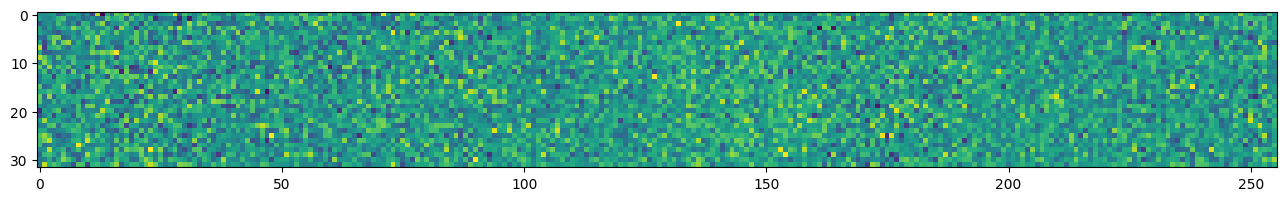

 29%|██▉       | 293/1000 [00:04<00:10, 68.59it/s]

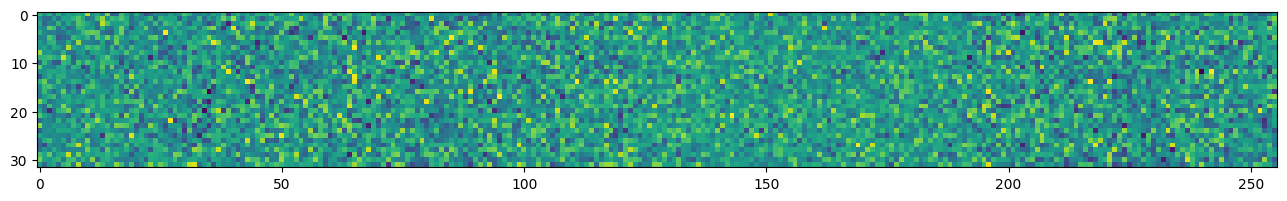

 40%|███▉      | 399/1000 [00:06<00:08, 67.13it/s]

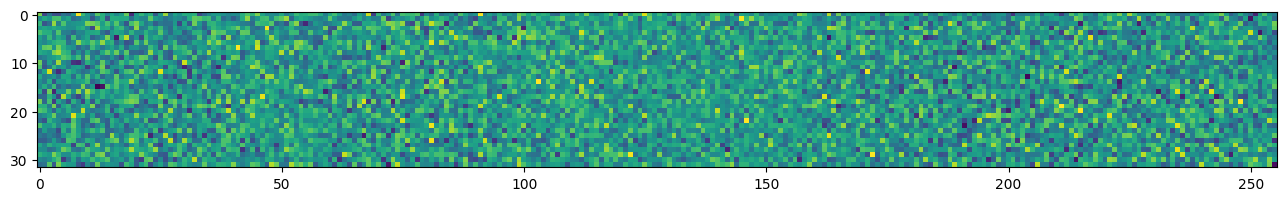

 50%|████▉     | 497/1000 [00:08<00:07, 68.01it/s]

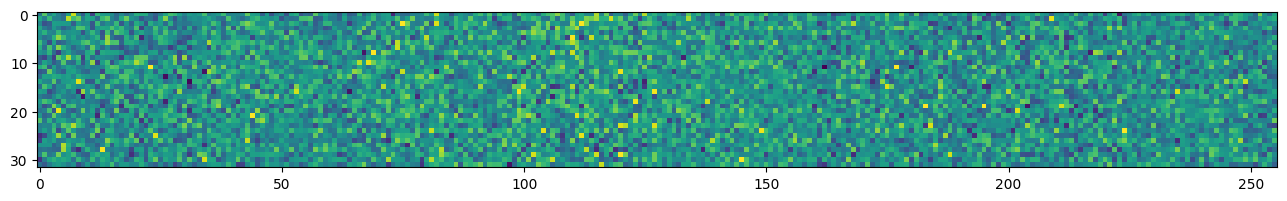

 60%|█████▉    | 597/1000 [00:09<00:06, 63.40it/s]

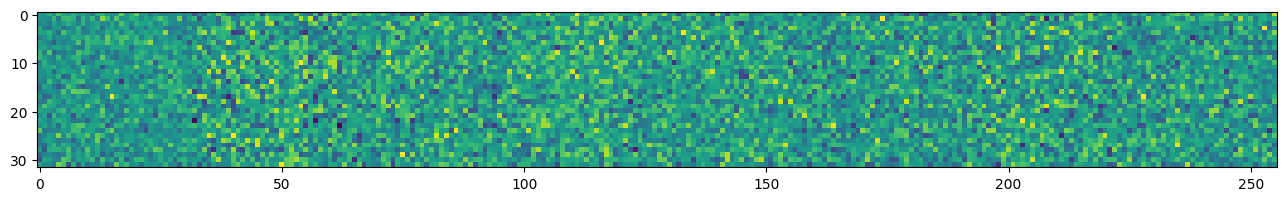

 69%|██████▉   | 694/1000 [00:11<00:05, 58.13it/s]

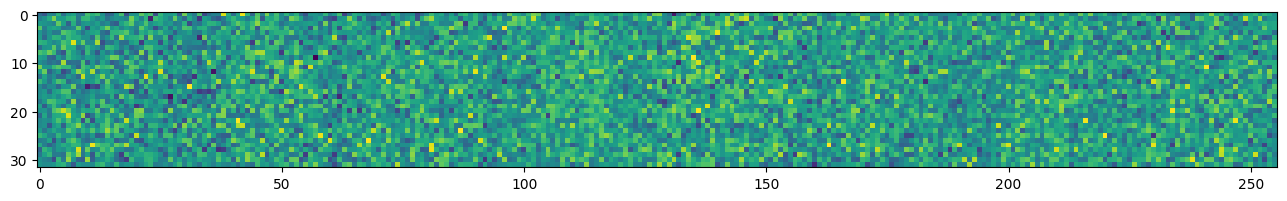

 80%|███████▉  | 796/1000 [00:13<00:03, 54.19it/s]

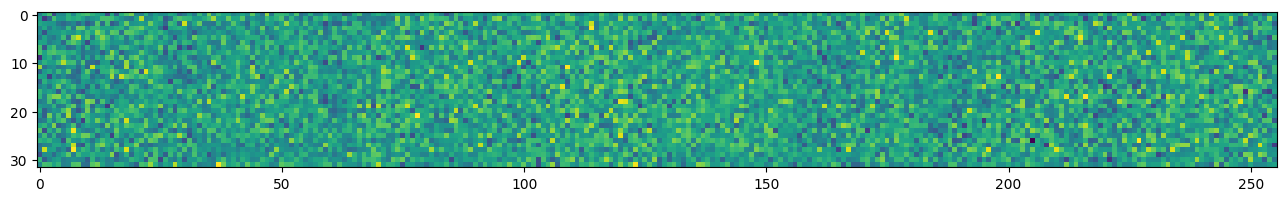

 89%|████████▉ | 893/1000 [00:15<00:01, 67.13it/s]

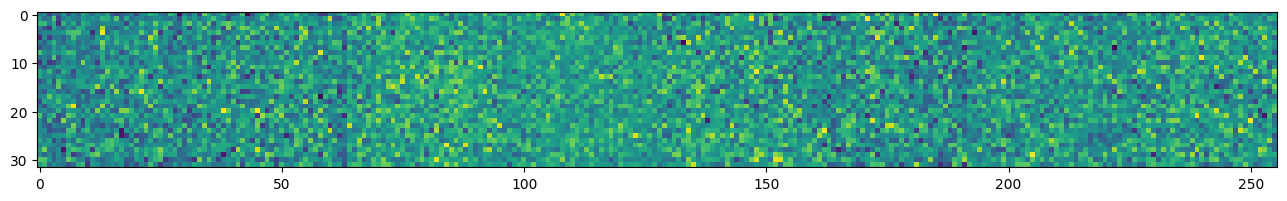

100%|█████████▉| 997/1000 [00:17<00:00, 67.21it/s]

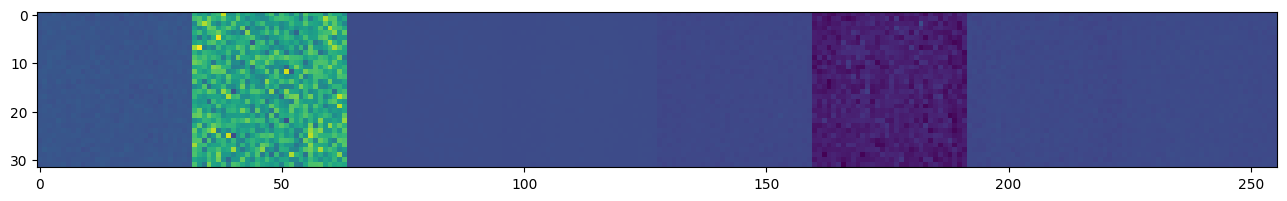

100%|██████████| 1000/1000 [00:17<00:00, 57.32it/s]


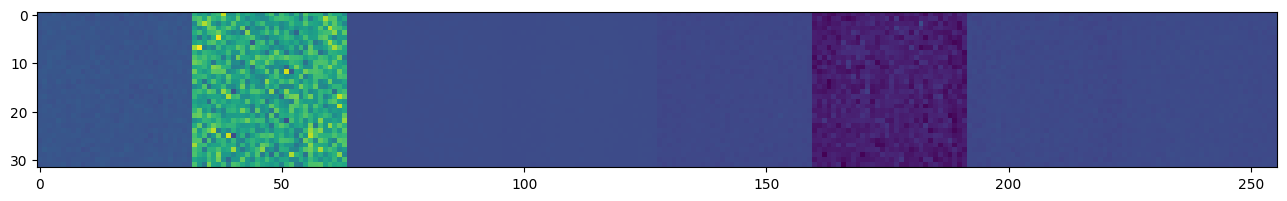

100%|██████████| 3750/3750 [04:00<00:00, 15.57it/s]


[Epoch: 4/10] [loss: 0.0315]


 10%|▉         | 97/1000 [00:01<00:16, 55.85it/s]

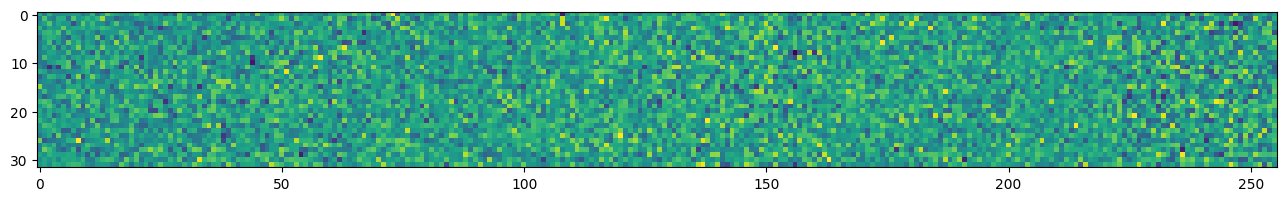

 20%|█▉        | 199/1000 [00:03<00:15, 52.74it/s]

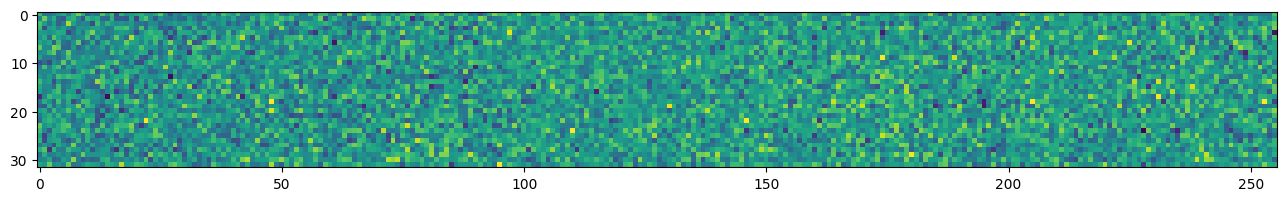

 30%|██▉       | 296/1000 [00:05<00:10, 65.55it/s]

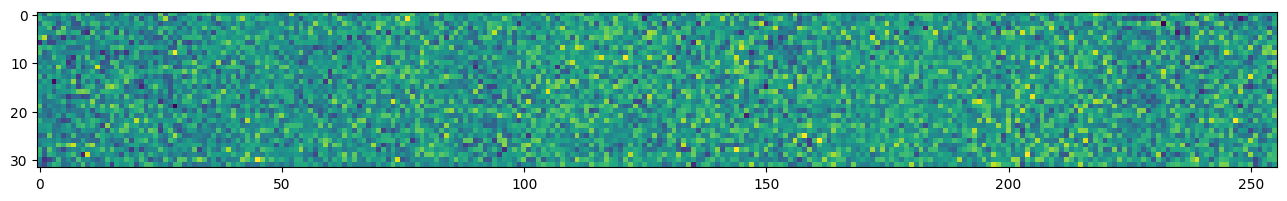

 39%|███▉      | 394/1000 [00:06<00:09, 67.03it/s]

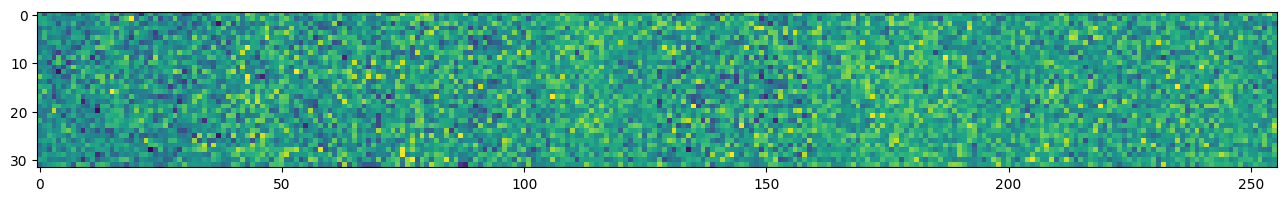

 50%|████▉     | 499/1000 [00:08<00:07, 67.92it/s]

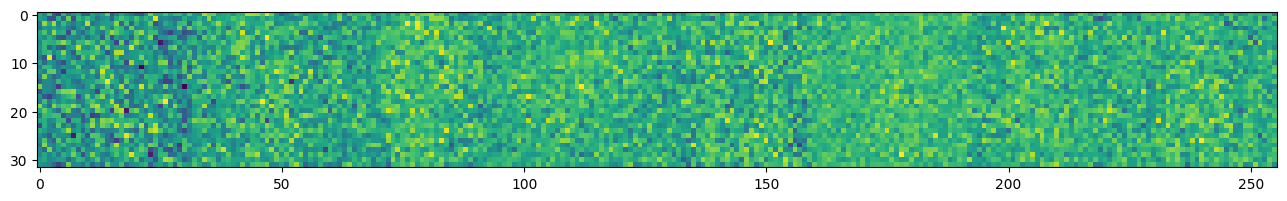

 60%|█████▉    | 597/1000 [00:10<00:06, 66.28it/s]

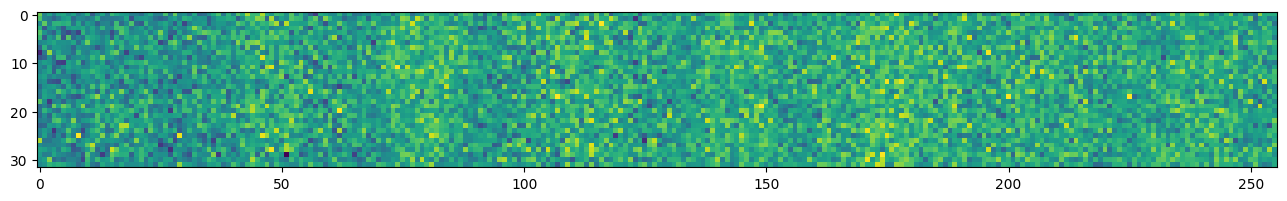

 70%|██████▉   | 695/1000 [00:11<00:04, 66.09it/s]

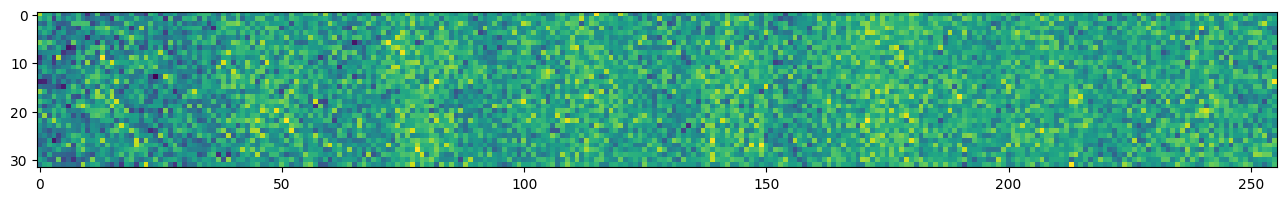

 79%|███████▉  | 793/1000 [00:13<00:03, 66.04it/s]

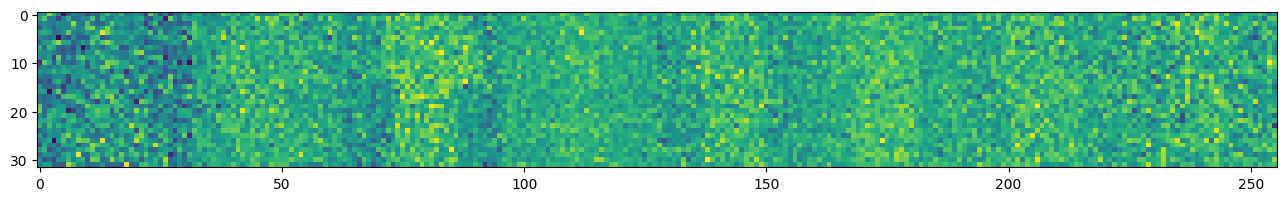

 90%|████████▉ | 896/1000 [00:15<00:01, 55.67it/s]

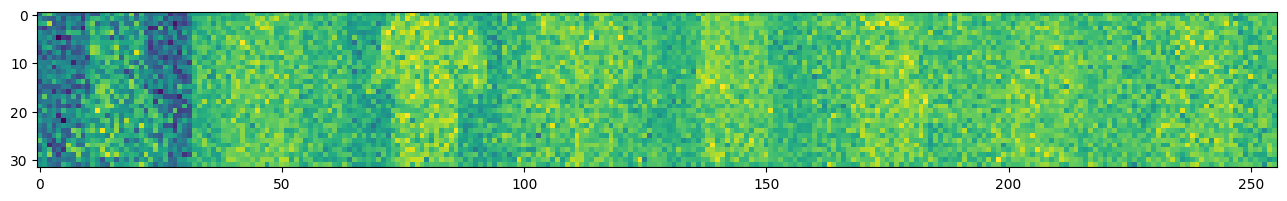

100%|█████████▉| 995/1000 [00:17<00:00, 66.86it/s]

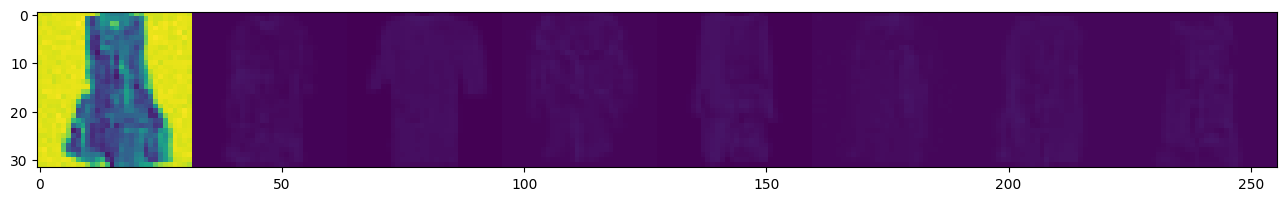

100%|██████████| 1000/1000 [00:17<00:00, 56.11it/s]


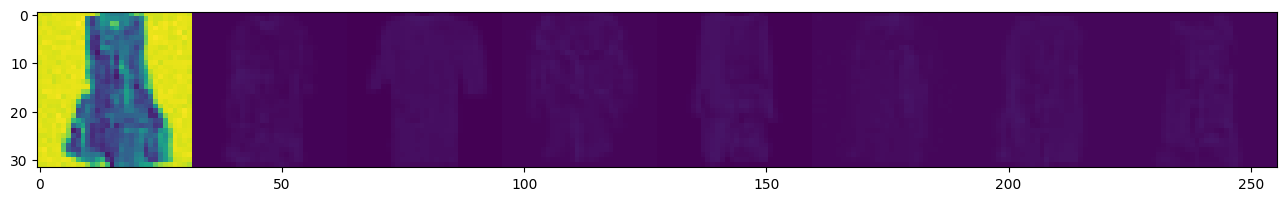

100%|██████████| 3750/3750 [04:01<00:00, 15.55it/s]


[Epoch: 5/10] [loss: 0.0299]


 10%|▉         | 97/1000 [00:01<00:14, 64.05it/s]

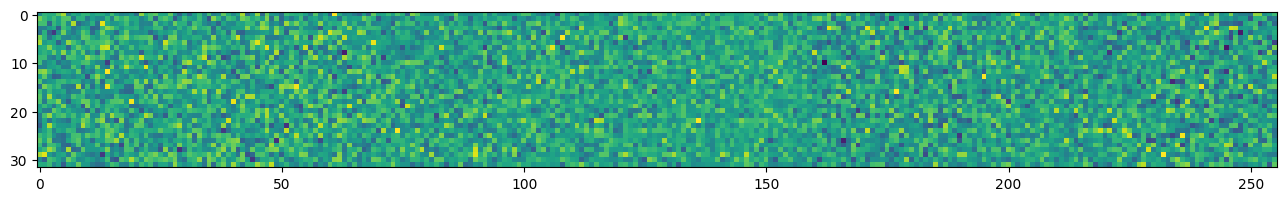

 20%|█▉        | 195/1000 [00:03<00:11, 67.09it/s]

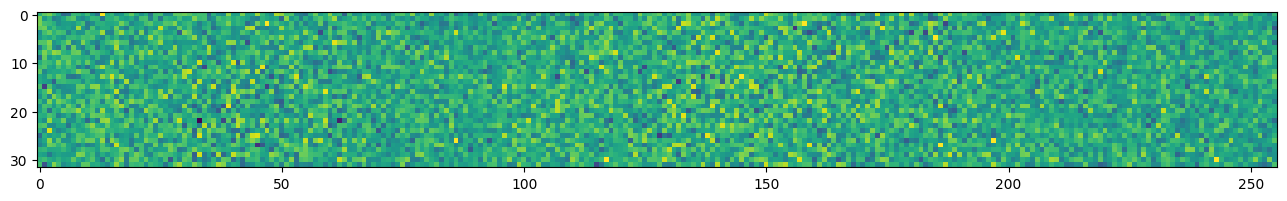

 29%|██▉       | 293/1000 [00:04<00:10, 66.01it/s]

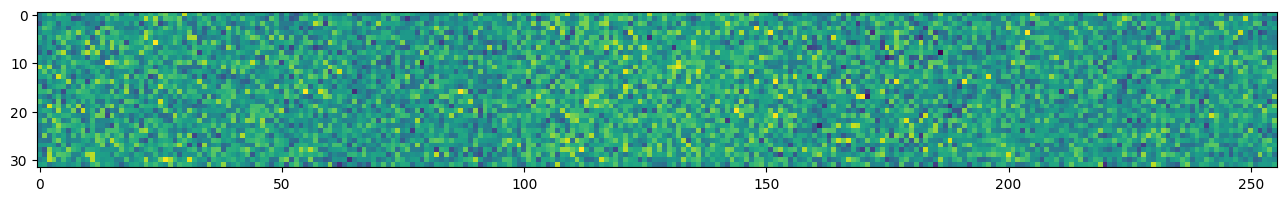

 39%|███▉      | 394/1000 [00:06<00:11, 51.04it/s]

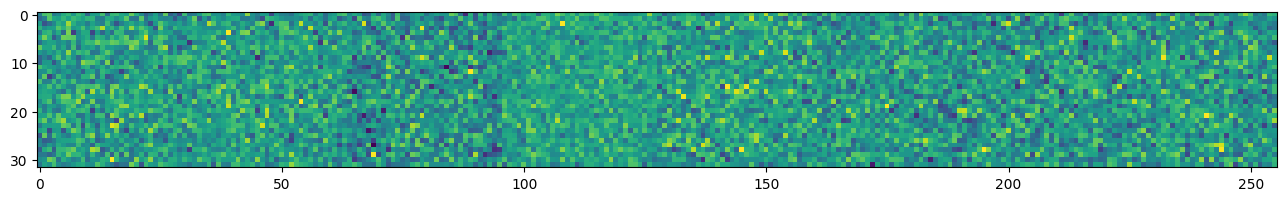

 50%|████▉     | 496/1000 [00:08<00:07, 63.65it/s]

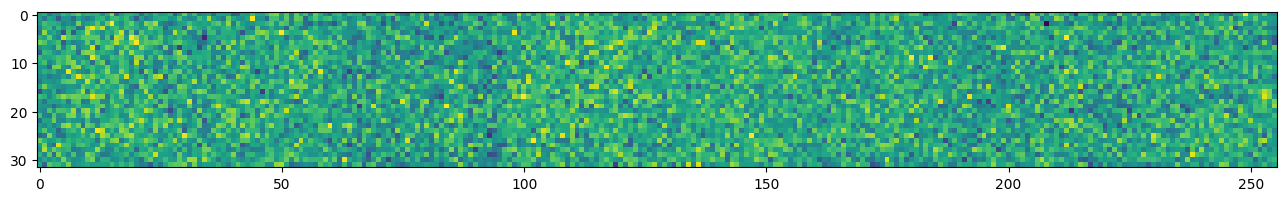

 59%|█████▉    | 594/1000 [00:10<00:06, 66.67it/s]

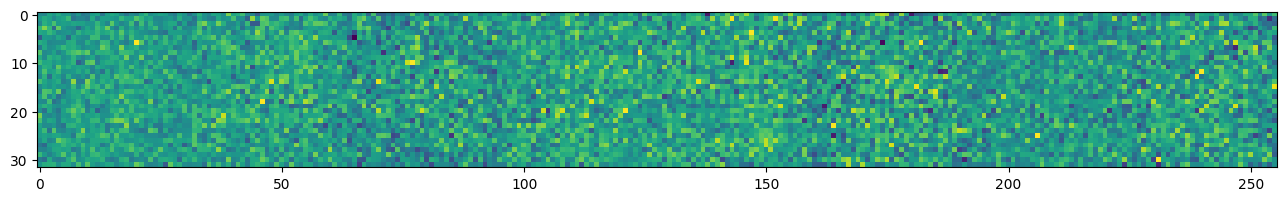

 70%|██████▉   | 698/1000 [00:12<00:04, 60.76it/s]

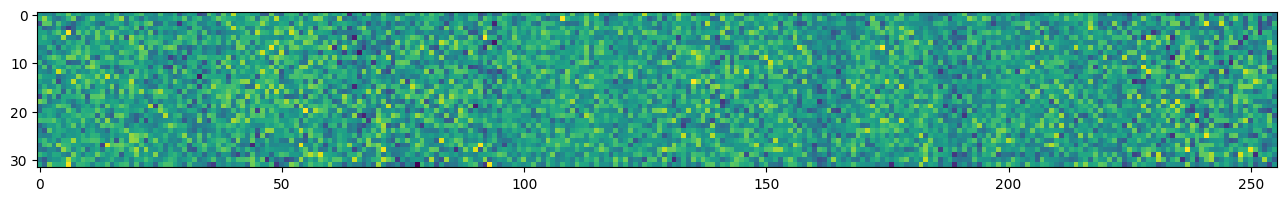

 80%|███████▉  | 795/1000 [00:13<00:03, 65.47it/s]

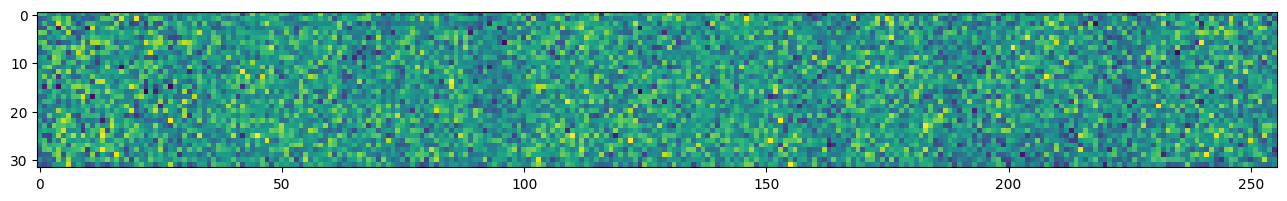

 89%|████████▉ | 893/1000 [00:15<00:01, 65.95it/s]

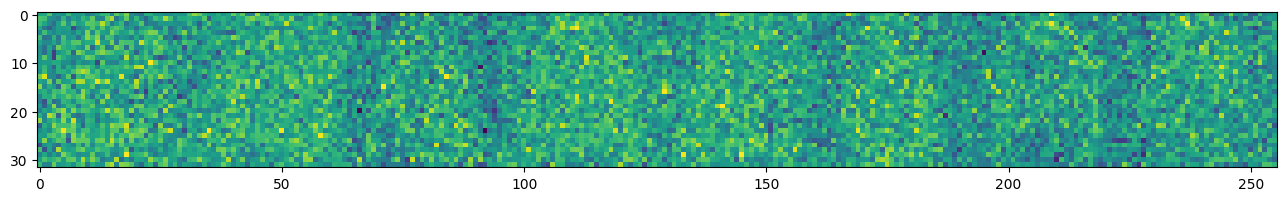

100%|█████████▉| 997/1000 [00:17<00:00, 66.24it/s]

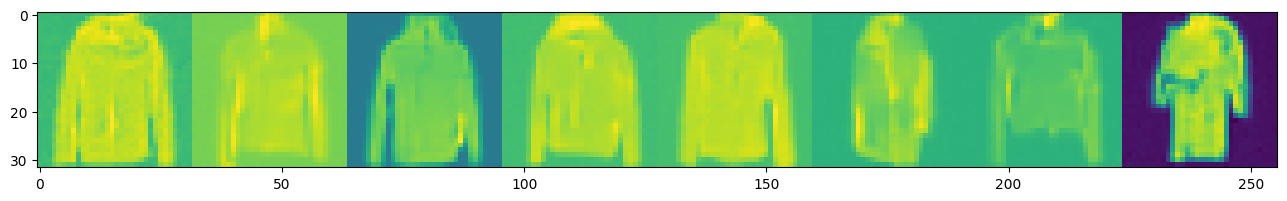

100%|██████████| 1000/1000 [00:17<00:00, 57.26it/s]


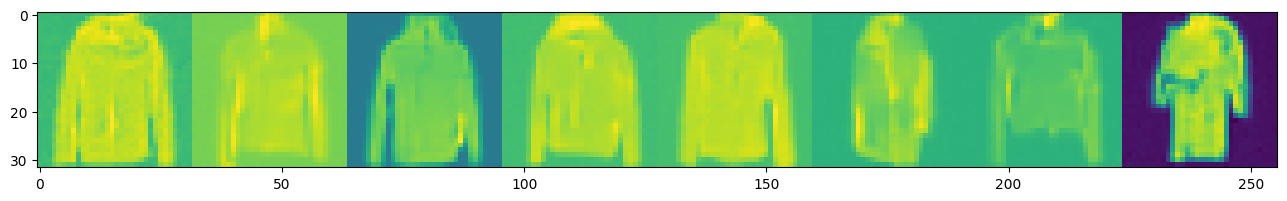

100%|██████████| 3750/3750 [04:01<00:00, 15.51it/s]


[Epoch: 6/10] [loss: 0.0295]


 10%|▉         | 98/1000 [00:01<00:17, 52.20it/s]

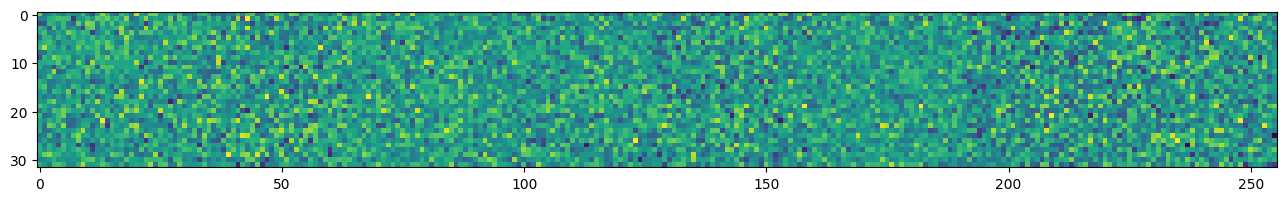

 20%|█▉        | 195/1000 [00:03<00:12, 65.11it/s]

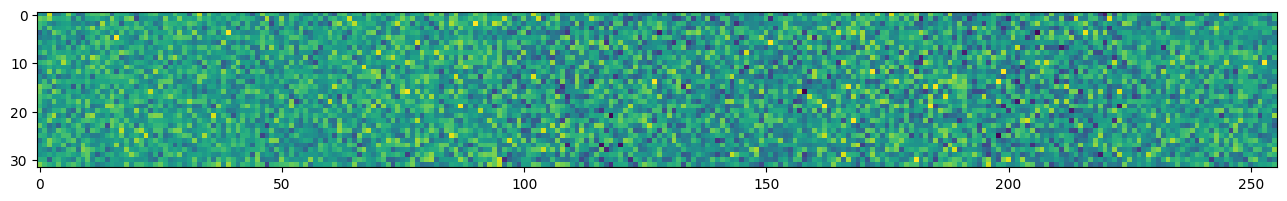

 30%|██▉       | 297/1000 [00:05<00:10, 65.69it/s]

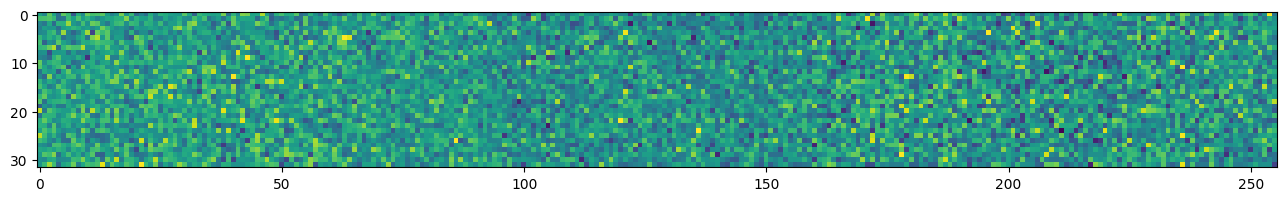

 40%|███▉      | 395/1000 [00:07<00:09, 65.44it/s]

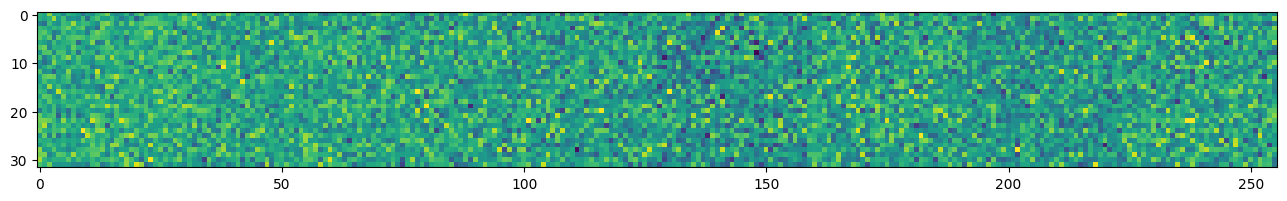

 50%|████▉     | 499/1000 [00:08<00:07, 65.14it/s]

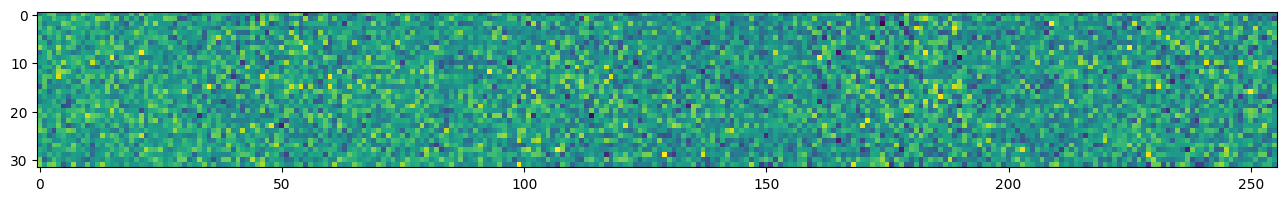

 60%|█████▉    | 597/1000 [00:10<00:06, 64.06it/s]

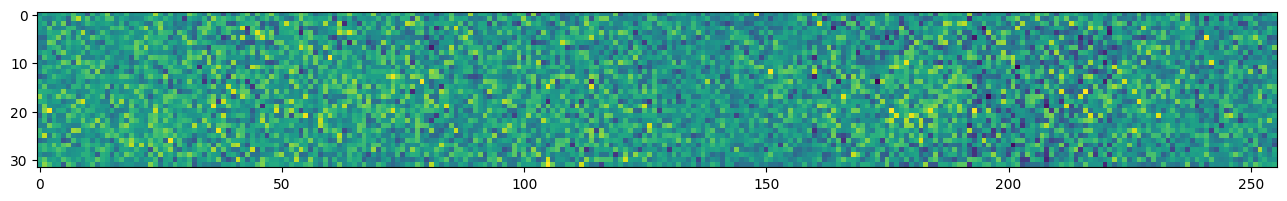

 70%|██████▉   | 695/1000 [00:12<00:05, 58.73it/s]

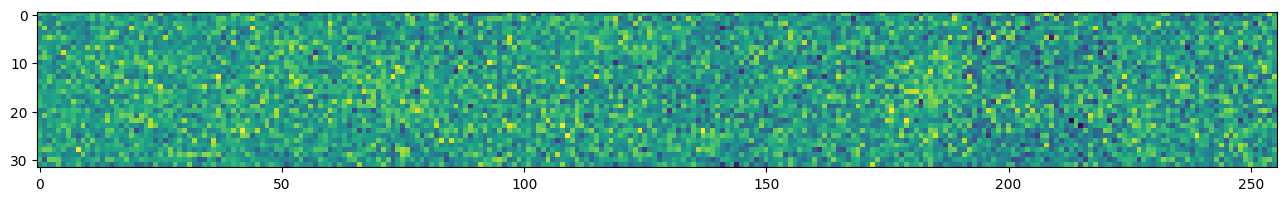

 80%|███████▉  | 797/1000 [00:14<00:03, 55.52it/s]

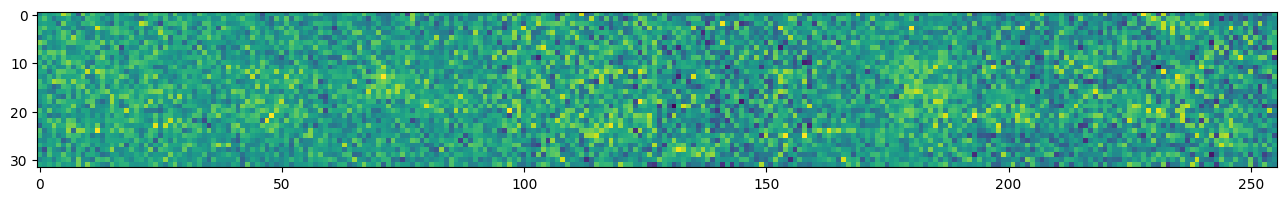

 89%|████████▉ | 893/1000 [00:16<00:01, 63.92it/s]

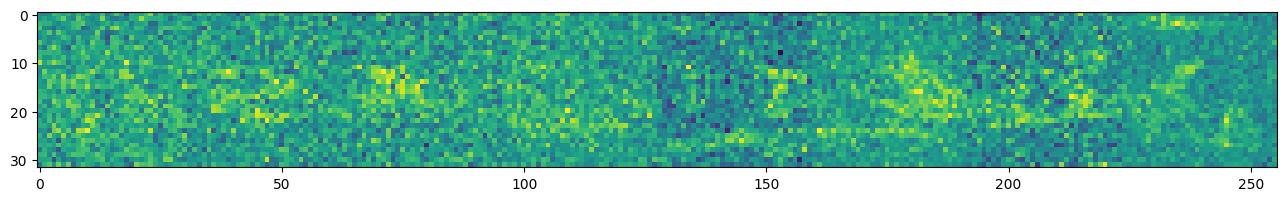

100%|█████████▉| 996/1000 [00:17<00:00, 62.92it/s]

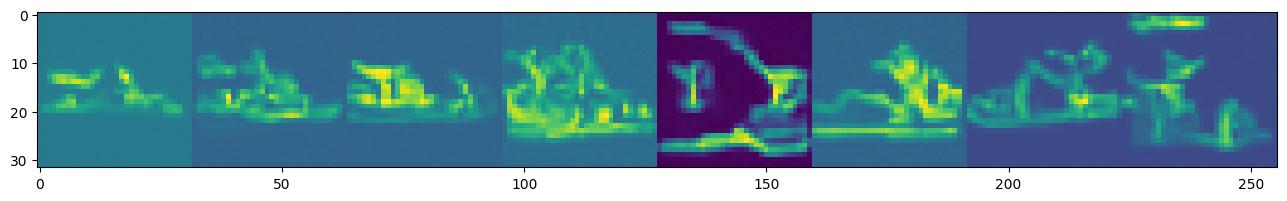

100%|██████████| 1000/1000 [00:18<00:00, 55.02it/s]


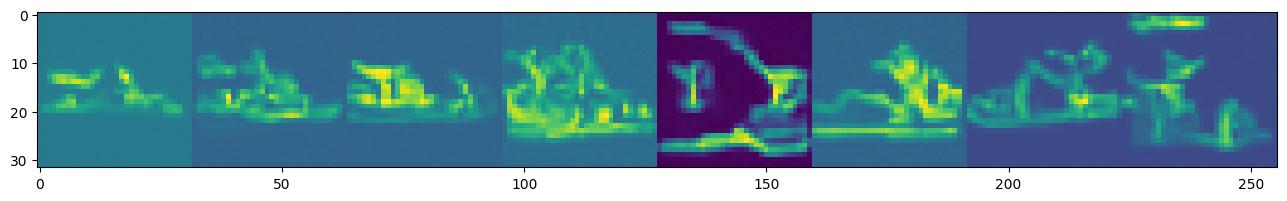

100%|██████████| 3750/3750 [04:03<00:00, 15.43it/s]


[Epoch: 7/10] [loss: 0.0288]


 10%|▉         | 99/1000 [00:01<00:14, 63.04it/s]

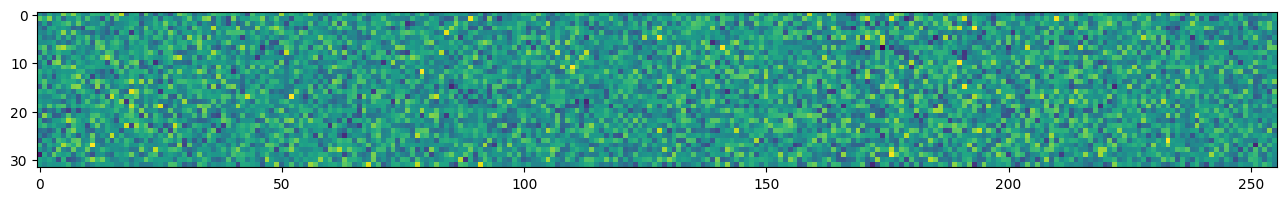

 20%|█▉        | 195/1000 [00:03<00:12, 62.44it/s]

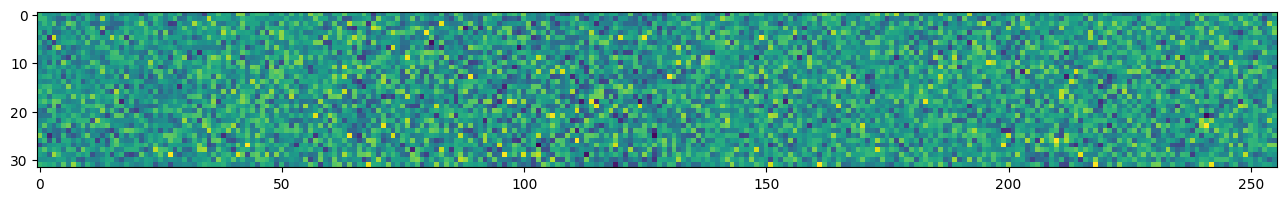

 30%|██▉       | 296/1000 [00:05<00:11, 61.55it/s]

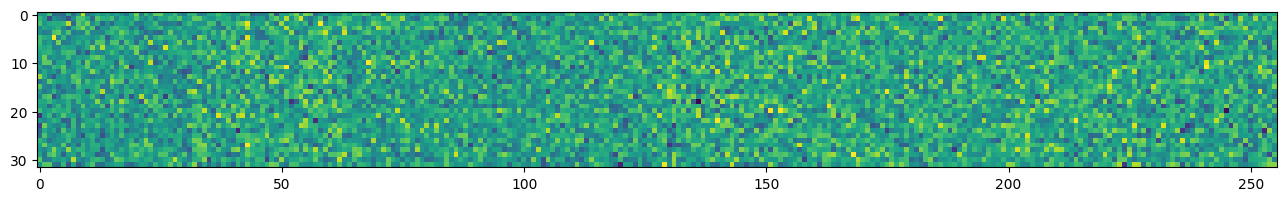

 40%|███▉      | 399/1000 [00:06<00:09, 63.43it/s]

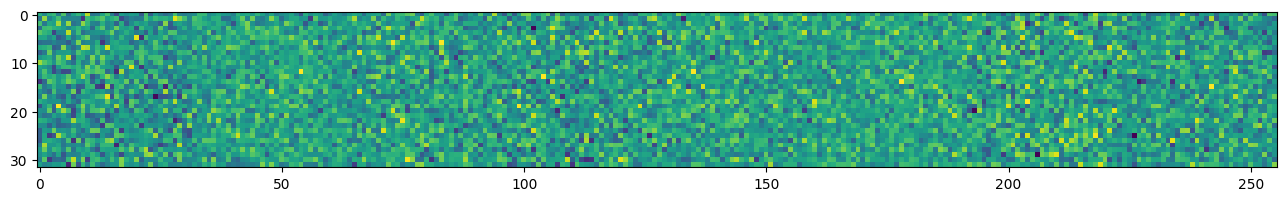

 50%|████▉     | 498/1000 [00:09<00:10, 46.23it/s]

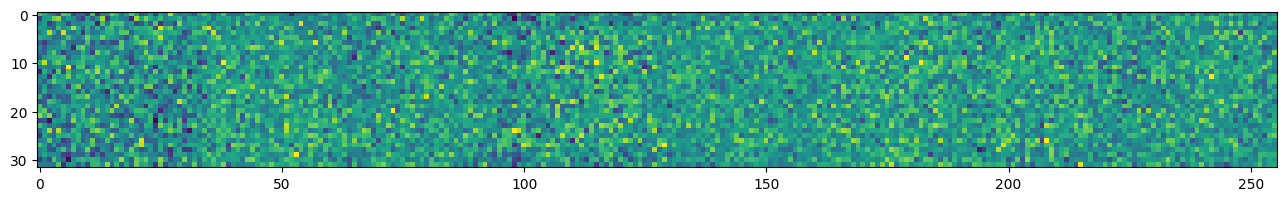

 60%|█████▉    | 599/1000 [00:11<00:06, 63.80it/s]

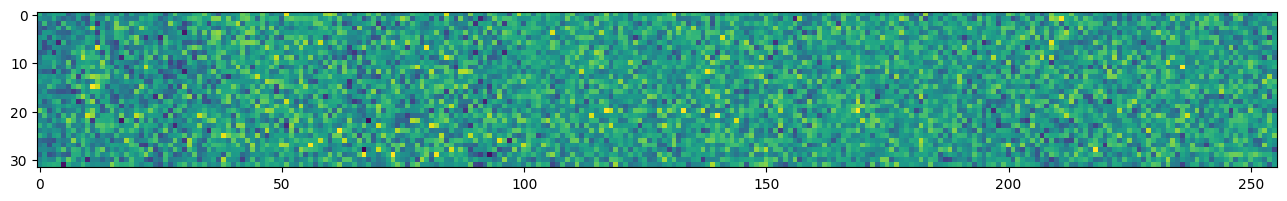

 70%|██████▉   | 696/1000 [00:12<00:05, 60.28it/s]

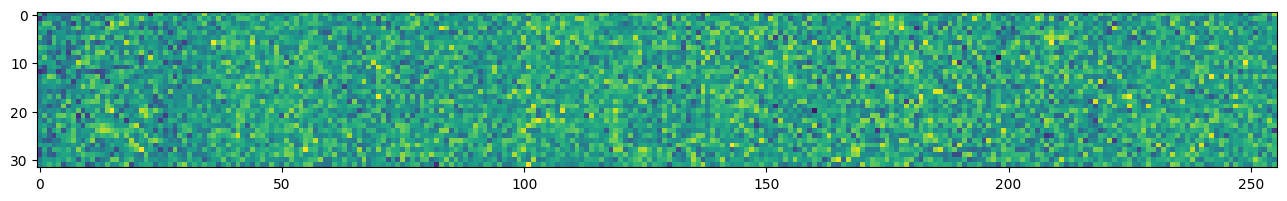

 80%|███████▉  | 799/1000 [00:14<00:03, 62.80it/s]

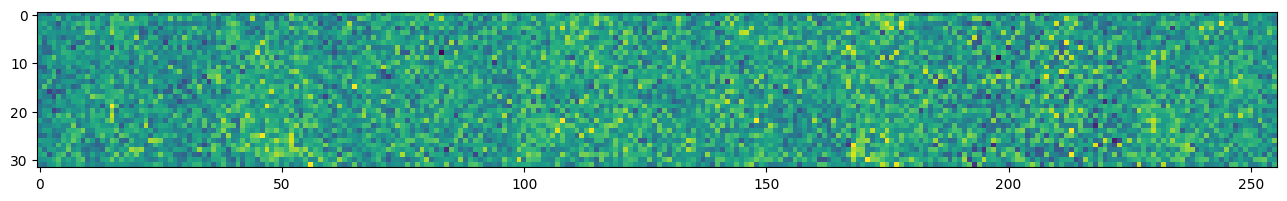

 90%|████████▉ | 896/1000 [00:16<00:01, 52.03it/s]

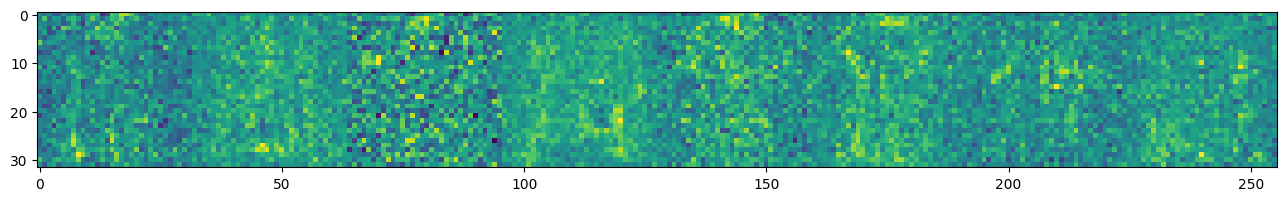

100%|█████████▉| 999/1000 [00:18<00:00, 63.40it/s]

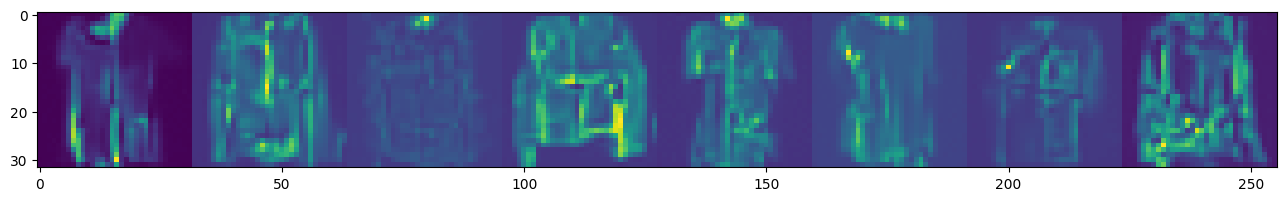

100%|██████████| 1000/1000 [00:18<00:00, 53.74it/s]


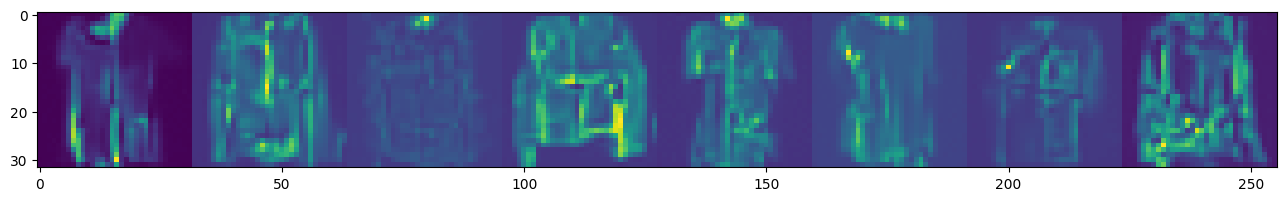

100%|██████████| 3750/3750 [04:22<00:00, 14.26it/s]


[Epoch: 8/10] [loss: 0.0286]


 10%|▉         | 99/1000 [00:03<00:35, 25.40it/s]

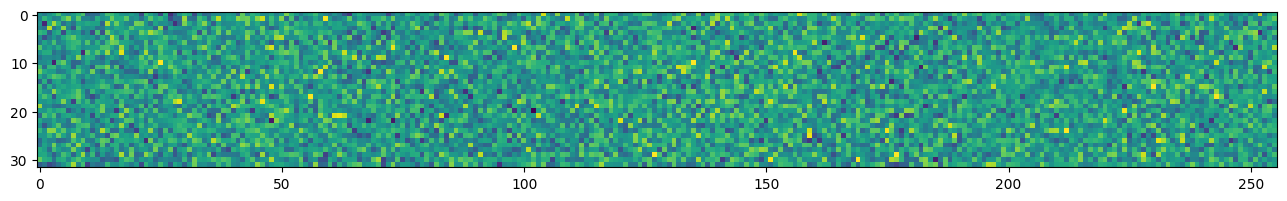

 20%|█▉        | 195/1000 [00:05<00:13, 58.35it/s]

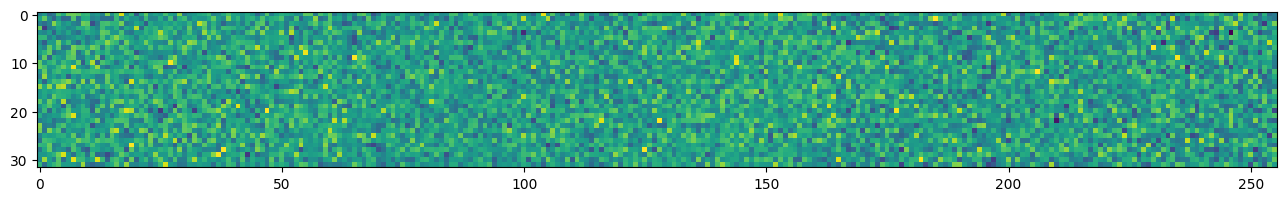

 30%|██▉       | 298/1000 [00:07<00:11, 63.62it/s]

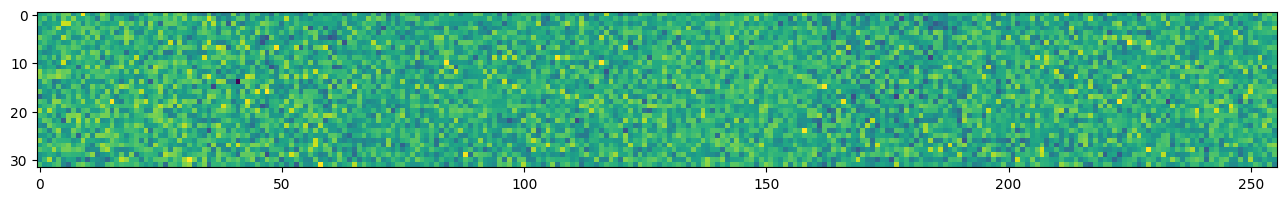

 40%|███▉      | 395/1000 [00:08<00:09, 60.93it/s]

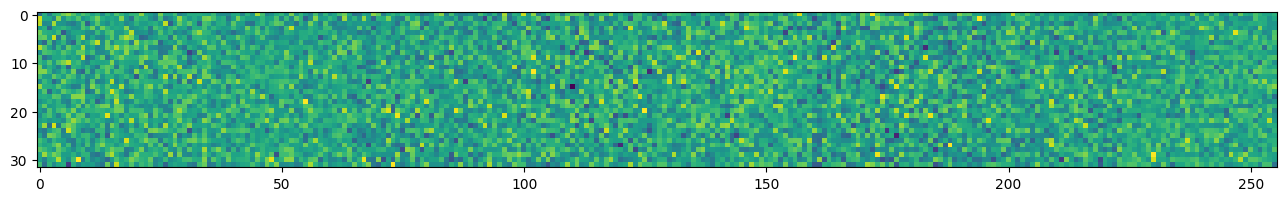

 49%|████▉     | 493/1000 [00:11<00:08, 61.04it/s]

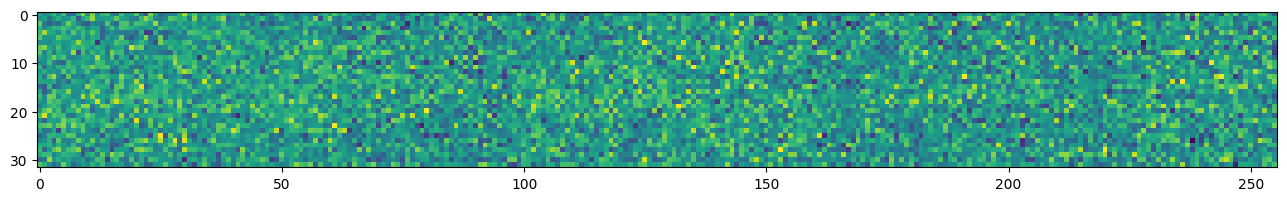

 60%|█████▉    | 596/1000 [00:12<00:06, 62.71it/s]

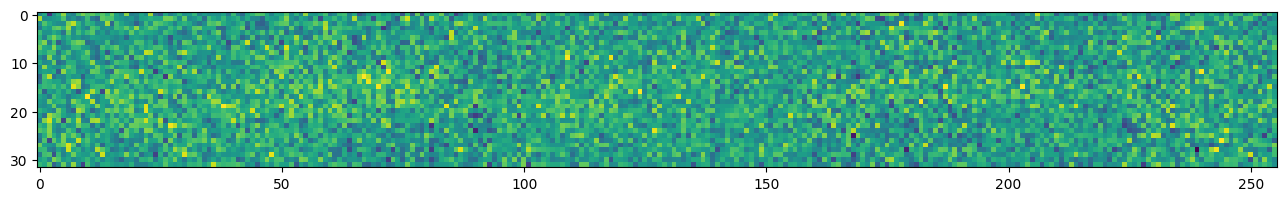

 70%|██████▉   | 695/1000 [00:14<00:05, 51.49it/s]

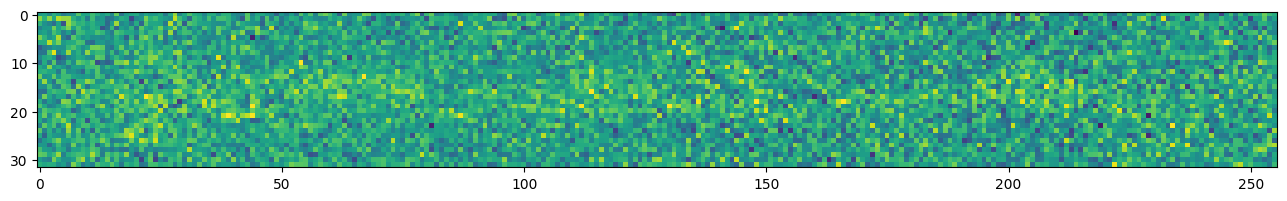

 80%|███████▉  | 796/1000 [00:17<00:04, 50.83it/s]

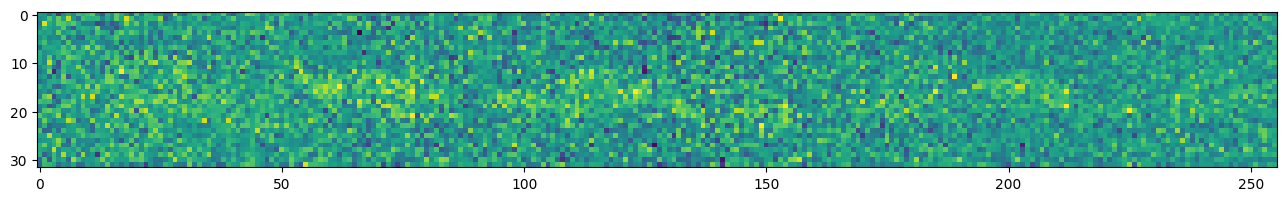

 90%|████████▉ | 899/1000 [00:19<00:01, 63.27it/s]

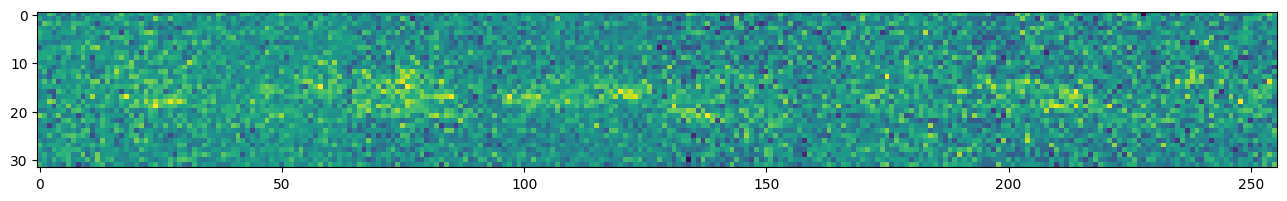

100%|█████████▉| 995/1000 [00:20<00:00, 61.18it/s]

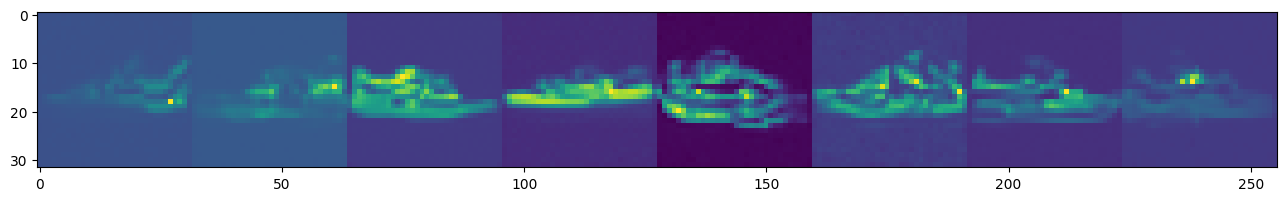

100%|██████████| 1000/1000 [00:21<00:00, 47.32it/s]


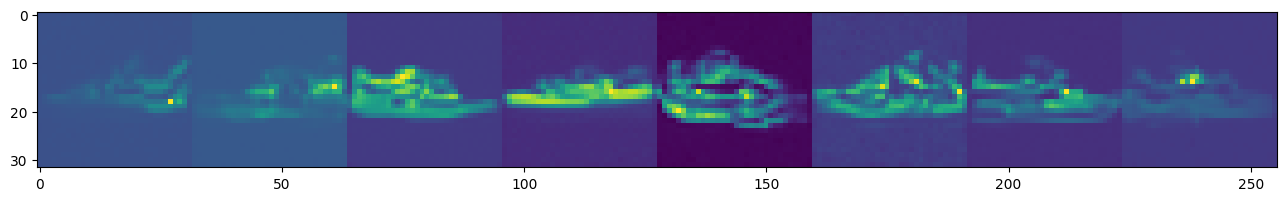

100%|██████████| 3750/3750 [04:09<00:00, 15.02it/s]


[Epoch: 9/10] [loss: 0.0277]


  9%|▉         | 93/1000 [00:01<00:14, 63.91it/s]

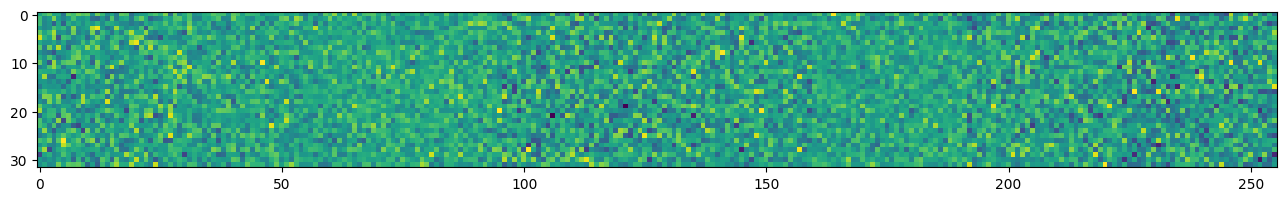

 20%|█▉        | 196/1000 [00:03<00:12, 63.79it/s]

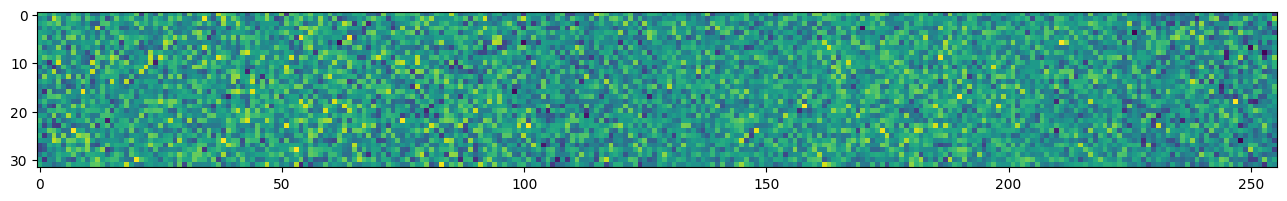

 29%|██▉       | 293/1000 [00:04<00:11, 62.81it/s]

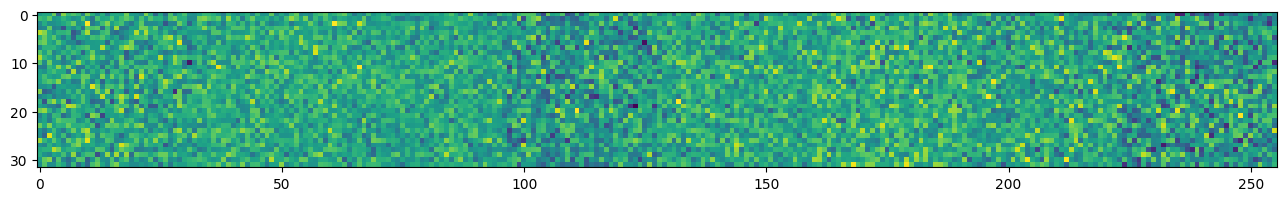

 40%|███▉      | 398/1000 [00:07<00:11, 52.04it/s]

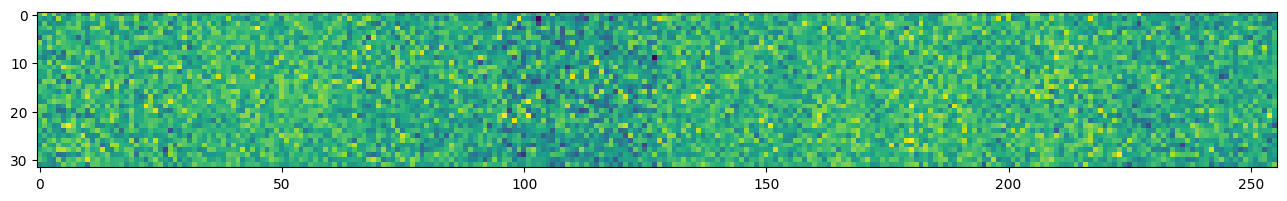

 50%|████▉     | 497/1000 [00:09<00:09, 51.67it/s]

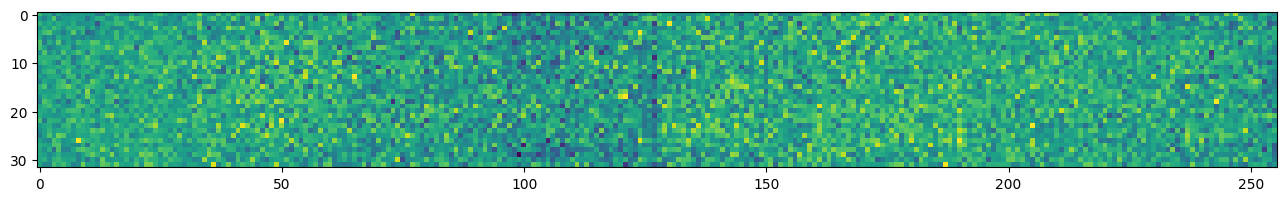

 60%|█████▉    | 597/1000 [00:11<00:06, 63.17it/s]

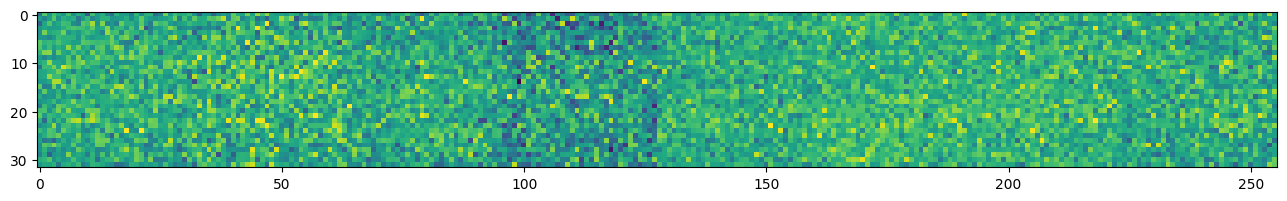

 70%|██████▉   | 695/1000 [00:12<00:04, 62.61it/s]

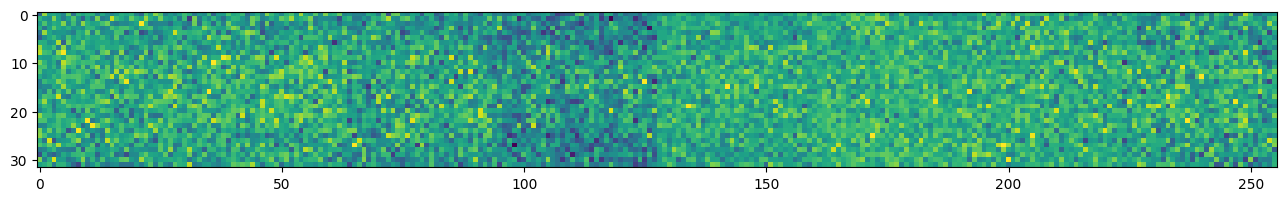

 80%|███████▉  | 797/1000 [00:14<00:03, 62.89it/s]

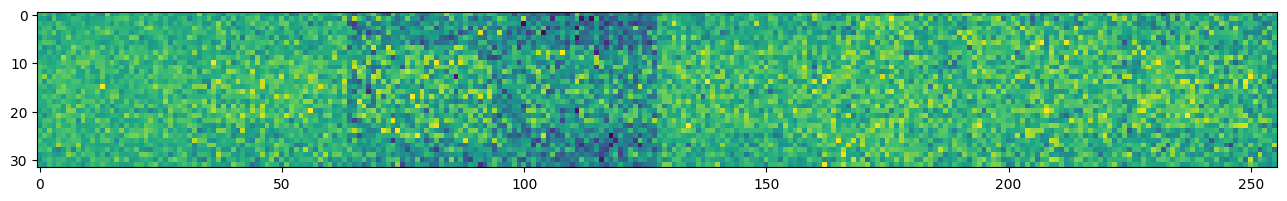

 89%|████████▉ | 894/1000 [00:16<00:01, 61.86it/s]

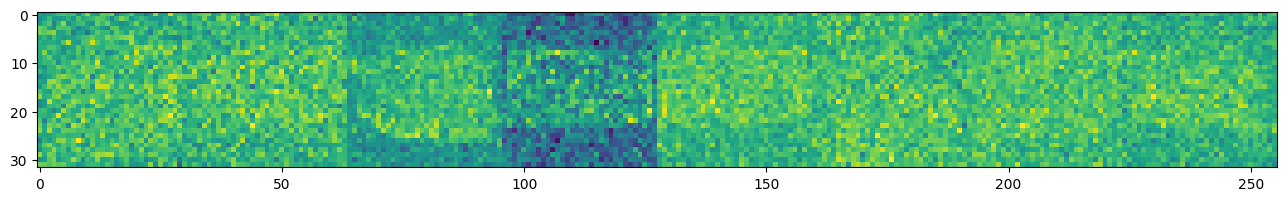

100%|█████████▉| 997/1000 [00:18<00:00, 62.72it/s]

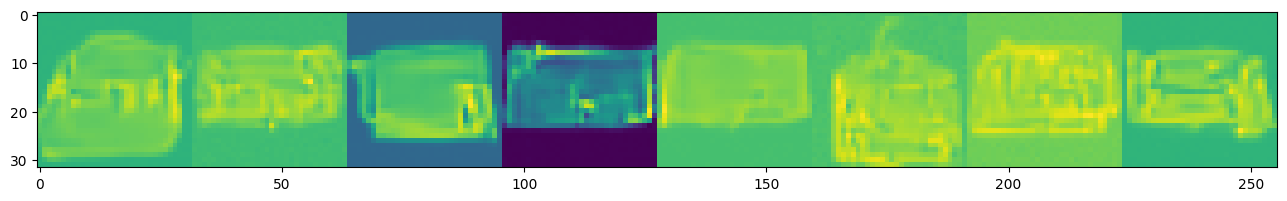

100%|██████████| 1000/1000 [00:18<00:00, 54.15it/s]


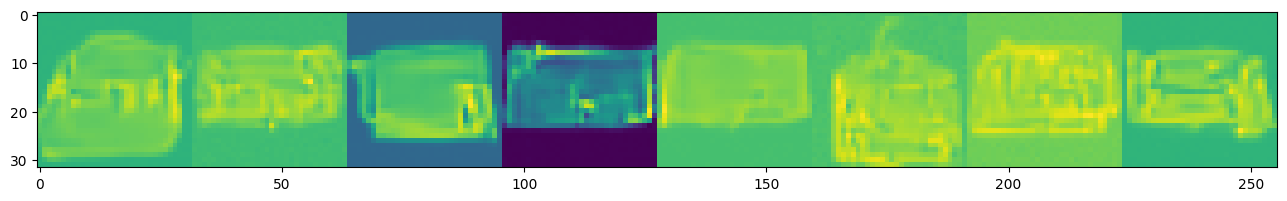

100%|██████████| 3750/3750 [04:06<00:00, 15.21it/s]


[Epoch: 10/10] [loss: 0.0277]


 10%|▉         | 98/1000 [00:01<00:14, 62.77it/s]

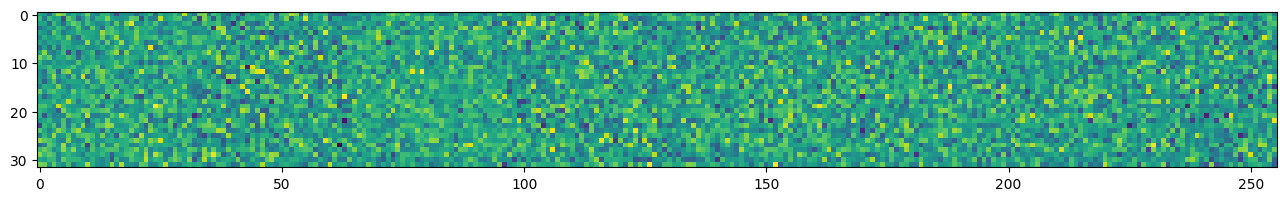

 19%|█▉        | 194/1000 [00:03<00:12, 64.39it/s]

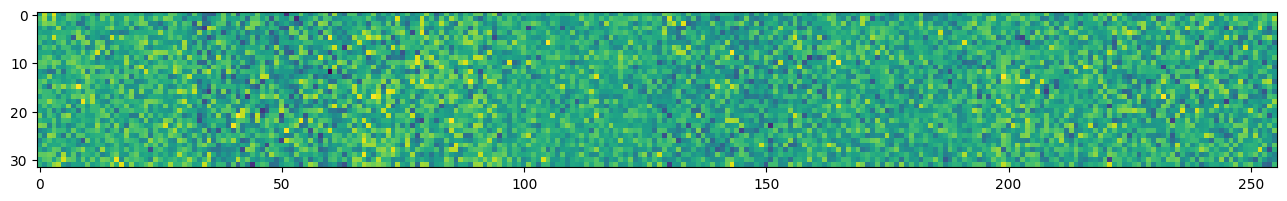

 30%|██▉       | 299/1000 [00:05<00:11, 61.29it/s]

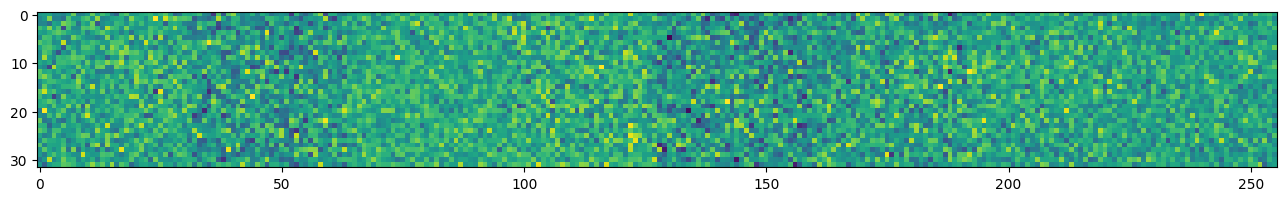

 40%|███▉      | 397/1000 [00:06<00:10, 57.84it/s]

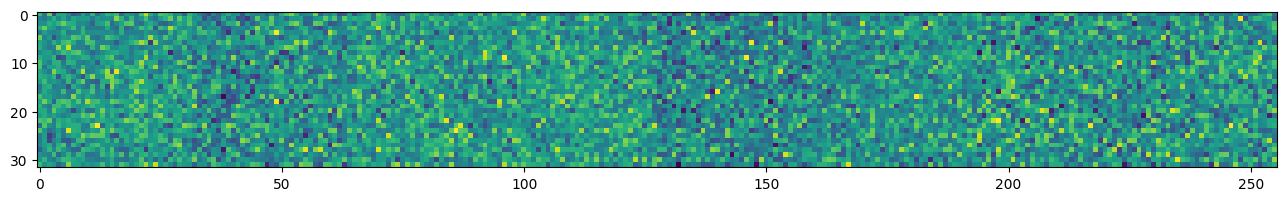

 50%|████▉     | 498/1000 [00:09<00:09, 54.19it/s]

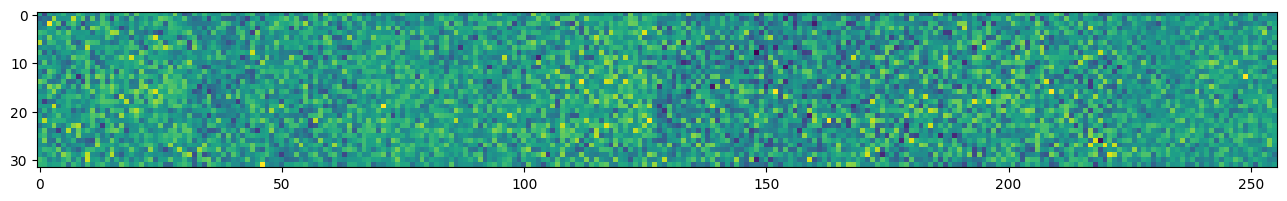

 59%|█████▉    | 594/1000 [00:11<00:07, 56.03it/s]

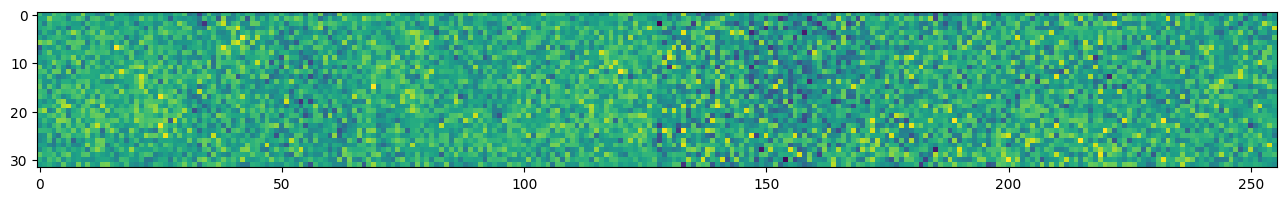

 70%|██████▉   | 695/1000 [00:12<00:04, 62.17it/s]

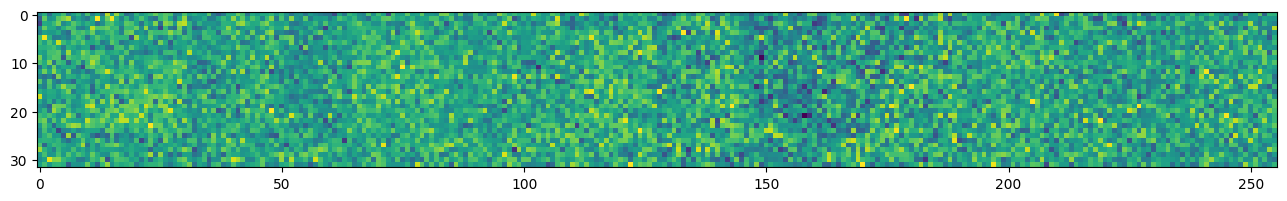

 80%|███████▉  | 798/1000 [00:14<00:03, 61.98it/s]

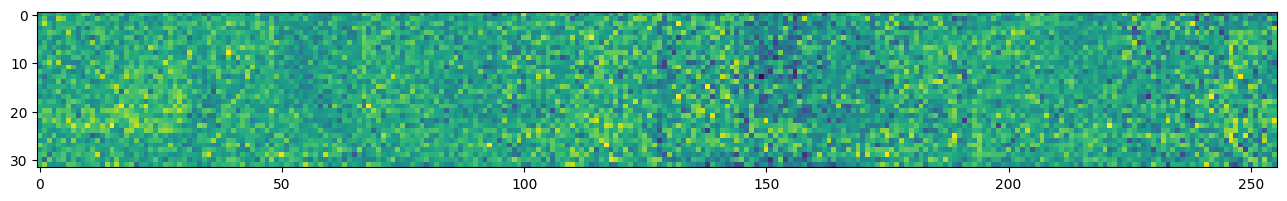

 90%|████████▉ | 895/1000 [00:16<00:01, 62.09it/s]

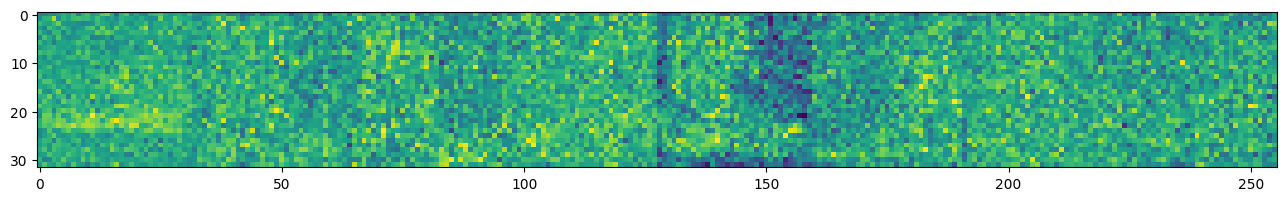

 99%|█████████▉| 993/1000 [00:18<00:00, 61.84it/s]

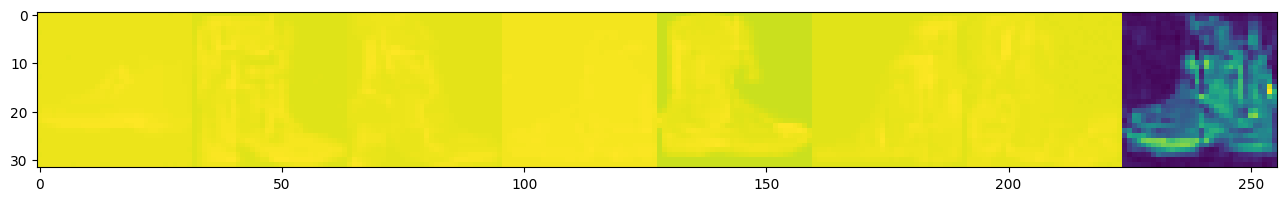

100%|██████████| 1000/1000 [00:18<00:00, 53.40it/s]


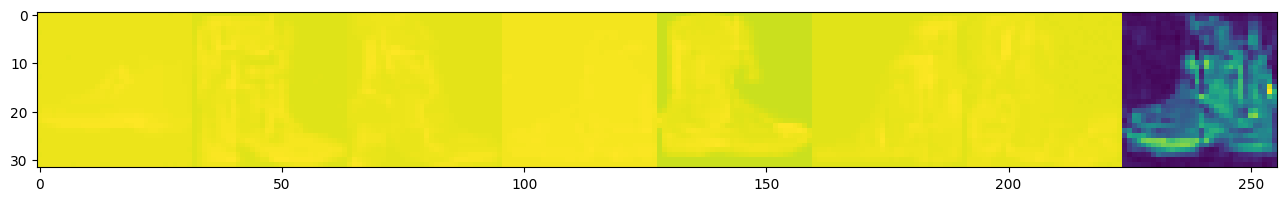

In [62]:
ddpm = DDPMManager() # You can pass your arguments to the call.

ddpm_history = ddpm.train(dataloader)

## Comparisons (10 points)

History of each training has been stored in `[MODEL]_history`. Plot the losses for each model. Also sample images from each model and compare your results. 

Text(0, 0.5, 'loss')

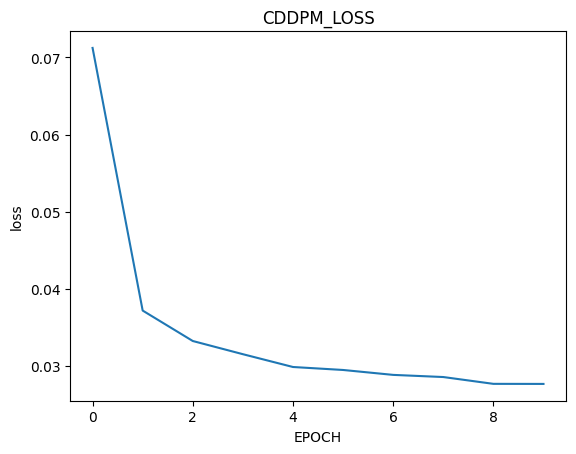

In [67]:
plt.plot(ddpm_history['loss'])
plt.title('CDDPM_LOSS')
plt.xlabel('EPOCH')
plt.ylabel('loss')